In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [4]:
# Assuming the file is in the root directory of your Colab environment
try:
  df = pd.read_csv("cleaned_data.csv")
  print(df.head()) # Display the first few rows of the DataFrame to verify successful import
except FileNotFoundError:
  print("Error: 'question4-stock-data.csv' not found in the root directory.")
except pd.errors.EmptyDataError:
    print("Error: 'question4-stock-data.csv' is empty.")
except pd.errors.ParserError:
    print("Error: 'question4-stock-data.csv' parsing error. Please check file format.")

         Date       Close        High         Low        Open    Volume
0  2017-01-03  118.550003  118.669998  117.830002  118.169998  204000.0
1  2017-01-04  121.190002  121.290001  120.139999  120.269997  250600.0
2  2017-01-05  120.440002  121.389999  120.320000  121.190002  525900.0
3  2017-01-06  120.129997  120.230003  119.410004  119.839996  171600.0
4  2017-01-09  119.739998  119.959999  119.470001  119.480003  135800.0


In [6]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [7]:
# Add a column for the day of the week (0 = Monday, 6 = Sunday)
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Optionally add a readable label
df['DayName'] = df['Date'].dt.day_name()


In [8]:
print(df.head())

        Date       Close        High         Low        Open    Volume  \
0 2017-01-03  118.550003  118.669998  117.830002  118.169998  204000.0   
1 2017-01-04  121.190002  121.290001  120.139999  120.269997  250600.0   
2 2017-01-05  120.440002  121.389999  120.320000  121.190002  525900.0   
3 2017-01-06  120.129997  120.230003  119.410004  119.839996  171600.0   
4 2017-01-09  119.739998  119.959999  119.470001  119.480003  135800.0   

   DayOfWeek    DayName  
0          1    Tuesday  
1          2  Wednesday  
2          3   Thursday  
3          4     Friday  
4          0     Monday  



Count of records by weekday:
DayOfWeek
Monday       348
Tuesday      394
Wednesday    394
Thursday     387
Friday       378
Name: count, dtype: int64


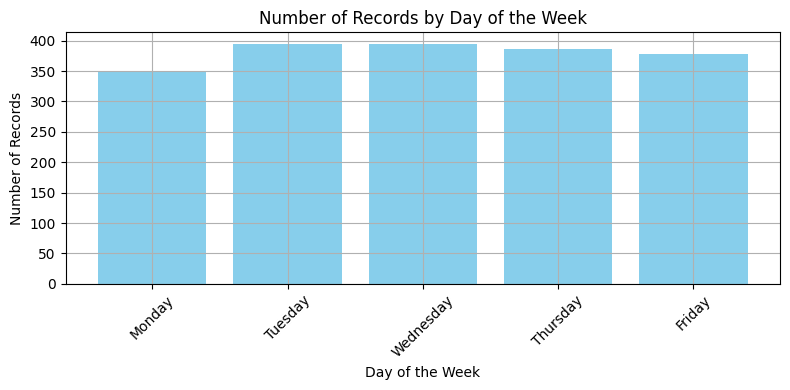

In [17]:
def plot_weekday_counts(df, date_column='Date'):
    """
    Calculates and plots the count of records for each weekday in the dataset.
    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the stock data.
    date_column : str, default 'Date'
        The column with date values.
    Returns:
    --------
    pd.Series
        Series with weekdays as index and counts as values.
    """
    # Create a column for the day of the week (0=Monday, 6=Sunday)
    df['DayOfWeek'] = df[date_column].dt.day_name()

    # Count the number of records for each weekday
    weekday_counts = df['DayOfWeek'].value_counts().reindex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], fill_value=0
    )

    # Display the counts
    print("\nCount of records by weekday:")
    print(weekday_counts)

    # Plot the counts as a bar chart
    plt.figure(figsize=(8, 4))
    plt.bar(weekday_counts.index, weekday_counts.values, color='skyblue')
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Records')
    plt.title('Number of Records by Day of the Week')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return weekday_counts

# Example usage
weekday_counts = plot_weekday_counts(df, date_column='Date')


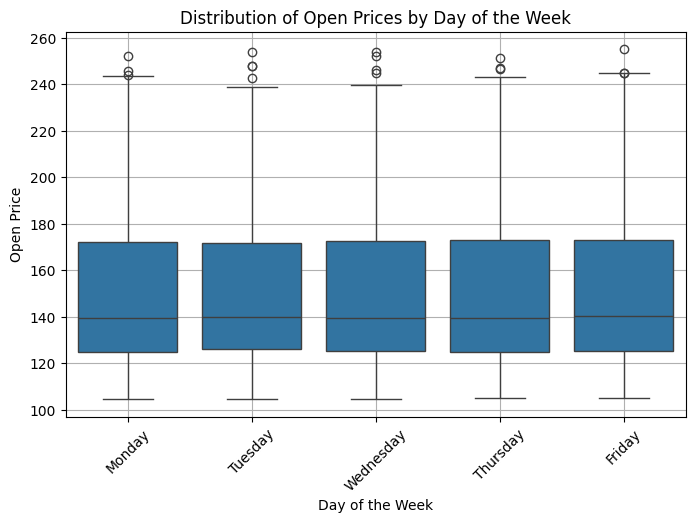

In [9]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='DayName', y='Open', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
plt.title('Distribution of Open Prices by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Open Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Outlier counts by day of the week:
Monday       3
Tuesday      4
Wednesday    4
Thursday     3
Friday       3
dtype: int64


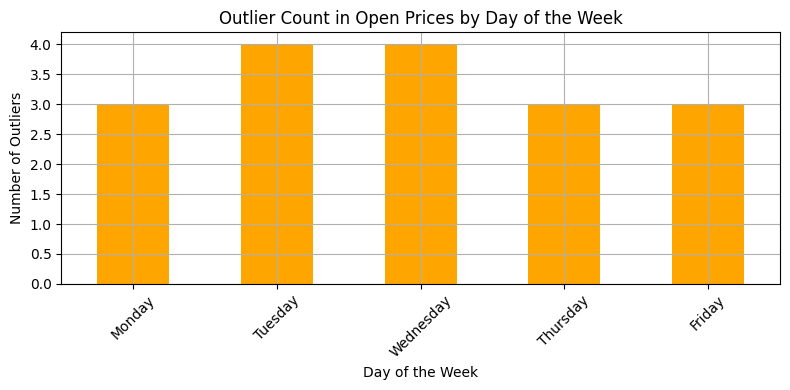

In [15]:
def get_outlier_count_by_day(df, value_column='Open', day_column='DayName'):
    """
    Calculates the number of outliers in the specified column grouped by day of the week.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the stock data.
    value_column : str, default 'Open'
        The column in which to identify outliers.
    day_column : str, default 'DayName'
        The column indicating the day of the week.

    Returns:
    --------
    pd.Series
        Series with days of the week as index and outlier counts as values.
    """

    # Prepare a dictionary to store the outlier counts
    outlier_counts = {}

    # Calculate outliers per day
    for day, group in df.groupby(day_column):
        # Calculate Q1, Q3, and IQR
        Q1 = group[value_column].quantile(0.25)
        Q3 = group[value_column].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers = group[(group[value_column] < lower_bound) | (group[value_column] > upper_bound)]
        outlier_counts[day] = len(outliers)

    # Convert to a Pandas Series and sort by day of the week order
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    outlier_series = pd.Series(outlier_counts).reindex(day_order, fill_value=0)

    # Display the outlier counts
    print("Outlier counts by day of the week:")
    print(outlier_series)

    # Plot the outlier counts as a bar chart
    outlier_series.plot(kind='bar', color='orange', figsize=(8, 4))
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Outliers')
    plt.title('Outlier Count in Open Prices by Day of the Week')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return outlier_series

# Example usage
outlier_counts = get_outlier_count_by_day(df, value_column='Open', day_column='DayName')


In [12]:
from scipy import stats

# Prepare data for ANOVA
groups = [df[df['DayOfWeek'] == i]['Open'].dropna() for i in range(5)]  # Monday to Friday

# Perform ANOVA
f_stat, p_value = stats.f_oneway(*groups)

print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"ANOVA p-value: {p_value:.4f}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference in Open prices between days of the week.")
else:
    print("No statistically significant difference in Open prices between days of the week.")


ANOVA F-statistic: 0.0667
ANOVA p-value: 0.9918
No statistically significant difference in Open prices between days of the week.


In [13]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Apply Tukey's test
tukey = pairwise_tukeyhsd(endog=df['Open'], groups=df['DayName'], alpha=0.05)
print(tukey)


  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2  meandiff p-adj   lower  upper  reject
--------------------------------------------------------
  Friday    Monday  -0.9728 0.9931 -7.2054 5.2599  False
  Friday  Thursday  -0.8802 0.9948 -6.9471 5.1867  False
  Friday   Tuesday  -0.3793 0.9998 -6.4195  5.661  False
  Friday Wednesday  -0.8134 0.9961 -6.8537 5.2268  False
  Monday  Thursday   0.0926    1.0 -6.1053 6.2904  False
  Monday   Tuesday   0.5935  0.999 -5.5782 6.7652  False
  Monday Wednesday   0.1593    1.0 -6.0124  6.331  False
Thursday   Tuesday   0.5009 0.9994 -5.5034 6.5052  False
Thursday Wednesday   0.0668    1.0 -5.9375 6.0711  False
 Tuesday Wednesday  -0.4341 0.9997 -6.4115 5.5432  False
--------------------------------------------------------


In [14]:
# Encode days of the week as integers (Monday = 0, ..., Friday = 4)
correlation = df['DayOfWeek'].corr(df['Open'])
print(f"Correlation between Day of Week and Open Price: {correlation:.4f}")


Correlation between Day of Week and Open Price: 0.0064


In [45]:
def analyze_x_by_y(
    df,
    x_column='Open',
    y_column='DayOfMonth',
    date_column='Date',
    regulate=False
):
    """
    Analyzes the distribution and outlier counts of a variable x grouped by a time-based feature y.
    Allows regulation of the data based on the count of records per y value.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the stock data.
    x_column : str, default 'Open'
        The column to analyze ('Open', 'Close', 'High', 'Low', 'Volume').
    y_column : str, default 'DayOfMonth'
        The column indicating the time-based grouping ('DayOfMonth', 'DayOfYear',
        'WeekNumber', 'DayOfWeek', 'WeekNoInMonth').
    date_column : str, default 'Date'
        The date column used to extract time-based features.
    regulate : bool, default False
        If True, normalizes the values of x by the count of records per y.

    Returns:
    --------
    None
    """

    from scipy import stats

    # Extract the desired time-based feature into y_column
    if y_column == 'DayOfMonth':
        df[y_column] = df[date_column].dt.day
    elif y_column == 'DayOfYear':
        df[y_column] = df[date_column].dt.dayofyear
    elif y_column == 'WeekNumber':
        df[y_column] = df[date_column].dt.isocalendar().week
    elif y_column == 'DayOfWeek':
        df[y_column] = df[date_column].dt.weekday  # Fixed: Removed parentheses
    elif y_column == 'WeekNoInMonth':
        df[y_column] = df[date_column].apply(lambda x: (x.day - 1) // 7 + 1)
    else:
        raise ValueError(f"Unsupported y_column: {y_column}")

    # 1. Count of Records by the y Column (C)
    record_counts = df[y_column].value_counts().sort_index()

    print(f"\nCount of records by {y_column} (C):")
    print(record_counts)

    # 2. Regulation of x if needed
    if regulate:
        df['Regulated_x'] = df[x_column] / df[y_column].map(record_counts)
        x_column = 'Regulated_x'

    # 3. Box Plot of x by y
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=y_column, y=x_column, data=df)
    plt.xlabel(y_column)
    plt.ylabel(f'{x_column} Value ({"Regulated" if regulate else "Raw"})')
    plt.title(f'Distribution of {x_column} by {y_column} {"(Regulated)" if regulate else ""}')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

    # 4. Outlier Count of x by y (Normalized by Record Count)
    outlier_counts = {}
    normalized_outliers = {}

    for y_value, group in df.groupby(y_column):
        # Calculate Q1, Q3, and IQR
        Q1 = group[x_column].quantile(0.25)
        Q3 = group[x_column].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers = group[(group[x_column] < lower_bound) | (group[x_column] > upper_bound)]
        outlier_counts[y_value] = len(outliers)

        # Normalized outlier count by total records for the day
        if y_value in record_counts.index and record_counts[y_value] != 0:
            normalized_outliers[y_value] = len(outliers) / record_counts[y_value]
        else:
            normalized_outliers[y_value] = 0

    print(f"\nOutlier counts by {y_column}:")
    print(outlier_counts)

    print(f"\nNormalized outlier counts (outliers/C) by {y_column}:")
    print(normalized_outliers)

    # Plot normalized outlier count by y
    plt.figure(figsize=(6, 3))
    plt.bar(normalized_outliers.keys(), normalized_outliers.values(), color='orange')
    plt.xlabel(y_column)
    plt.ylabel('Normalized Outlier Count (Outliers/C)')
    plt.title(f'Outlier Proportion of {x_column} by {y_column} {"(Regulated)" if regulate else ""}')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

    # 5. ANOVA Test on x by y
    groups = [group[x_column].dropna() for _, group in df.groupby(y_column)]
    f_stat, p_value = stats.f_oneway(*groups)

    print(f"\nANOVA Test Results for {x_column} by {y_column}:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_value:.4f}")

    if p_value < 0.05:
        print(f"Statistically significant difference in {x_column} by {y_column}.")
    else:
        print(f"No statistically significant difference in {x_column} by {y_column}.")

    # 6. Correlation Test of x with y (if y is numeric)
    if pd.api.types.is_numeric_dtype(df[y_column]):
        correlation, corr_p_value = stats.pearsonr(df[y_column], df[x_column])
        print(f"\nCorrelation between {x_column} and {y_column}:")
        print(f"Correlation coefficient: {correlation:.4f}")
        print(f"p-value: {corr_p_value:.4f}")

        if corr_p_value < 0.05:
            print(f"Statistically significant correlation between {x_column} and {y_column}.")
        else:
            print(f"No statistically significant correlation between {x_column} and {y_column}.")
    else:
        print(f"\nCannot perform correlation test for non-numeric y_column: {y_column}")


In [46]:
def test_all_combinations(df, date_column='Date', regulateOn=False):
    """
    Tests all possible combinations of x (price metrics) and y (time-based features)
    with optional regulation.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the stock data.
    date_column : str, default 'Date'
        The column containing date information.
    regulateOn : bool, default False
        If True, regulation will be applied to normalize data by record counts.

    Returns:
    --------
    None
    """

    # Possible x (price metric) and y (time-based feature) values
    # x_columns = ['Open', 'Close', 'High', 'Low', 'Volume']
    x_columns = ['Open',  'High', 'Volume']
    # y_columns = ['DayOfMonth', 'DayOfYear', 'WeekNumber', 'DayOfWeek', 'WeekNoInMonth']
    y_columns = ['DayOfMonth', 'WeekNumber', 'DayOfWeek', 'WeekNoInMonth']

    # Iterate over all combinations of x, y, and regulation
    for x in x_columns:
        for y in y_columns:
            print(f"\n=== Analyzing {x} by {y} (Regulated: {regulateOn}) ===")
            try:
                analyze_x_by_y(
                    df,
                    x_column=x,
                    y_column=y,
                    date_column=date_column,
                    regulate=regulateOn
                )
            except Exception as e:
                print(f"Error while analyzing {x} by {y} (Regulated: {regulateOn})")
                print(f"Error: {e}")



=== Analyzing Open by DayOfMonth (Regulated: False) ===

Count of records by DayOfMonth (C):
DayOfMonth
1     58
2     59
3     65
4     56
5     63
6     67
7     61
8     65
9     64
10    65
11    65
12    64
13    67
14    63
15    62
16    65
17    60
18    62
19    61
20    57
21    66
22    67
23    64
24    61
25    58
26    66
27    62
28    60
29    57
30    54
31    37
Name: count, dtype: int64


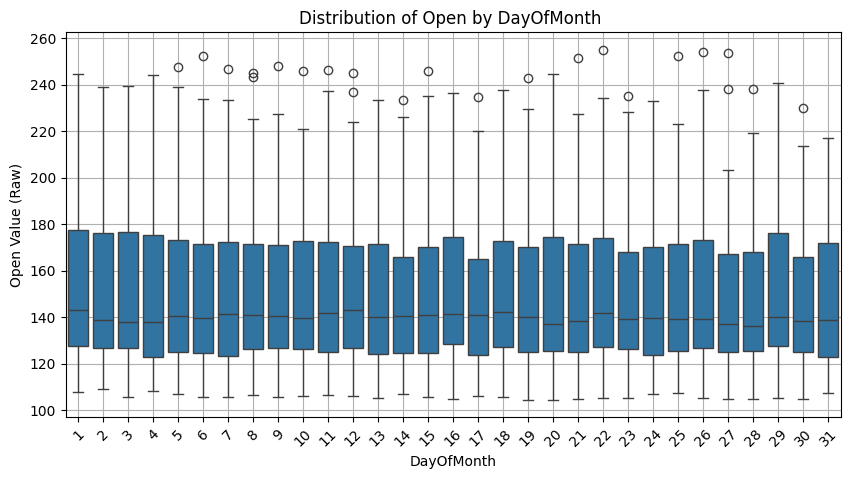


Outlier counts by DayOfMonth:
{1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 2, 9: 1, 10: 1, 11: 1, 12: 2, 13: 0, 14: 1, 15: 1, 16: 0, 17: 1, 18: 0, 19: 1, 20: 0, 21: 1, 22: 1, 23: 1, 24: 0, 25: 1, 26: 1, 27: 2, 28: 1, 29: 0, 30: 1, 31: 0}

Normalized outlier counts (outliers/C) by DayOfMonth:
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.015873015873015872, 6: 0.014925373134328358, 7: 0.01639344262295082, 8: 0.03076923076923077, 9: 0.015625, 10: 0.015384615384615385, 11: 0.015384615384615385, 12: 0.03125, 13: 0.0, 14: 0.015873015873015872, 15: 0.016129032258064516, 16: 0.0, 17: 0.016666666666666666, 18: 0.0, 19: 0.01639344262295082, 20: 0.0, 21: 0.015151515151515152, 22: 0.014925373134328358, 23: 0.015625, 24: 0.0, 25: 0.017241379310344827, 26: 0.015151515151515152, 27: 0.03225806451612903, 28: 0.016666666666666666, 29: 0.0, 30: 0.018518518518518517, 31: 0.0}


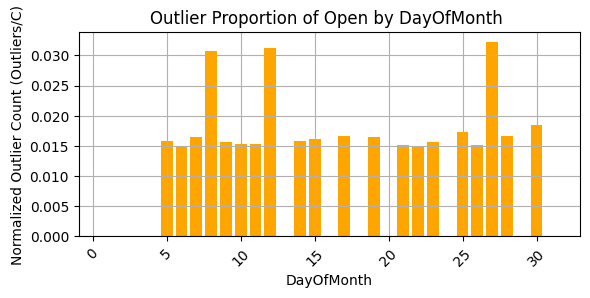


ANOVA Test Results for Open by DayOfMonth:
F-statistic: 0.1694
p-value: 1.0000
No statistically significant difference in Open by DayOfMonth.

Correlation between Open and DayOfMonth:
Correlation coefficient: -0.0187
p-value: 0.4157
No statistically significant correlation between Open and DayOfMonth.

=== Analyzing Open by WeekNumber (Regulated: False) ===

Count of records by WeekNumber (C):
WeekNumber
1     33
2     37
3     30
4     37
5     38
6     39
7     38
8     32
9     39
10    37
11    39
12    36
13    33
14    35
15    35
16    38
17    39
18    37
19    37
20    37
21    38
22    30
23    39
24    38
25    36
26    39
27    31
28    37
29    38
30    38
31    39
32    37
33    35
34    40
35    38
36    32
37    35
38    39
39    37
40    39
41    40
42    37
43    39
44    34
45    37
46    38
47    34
48    34
49    36
50    39
51    38
52    31
53     3
Name: count, dtype: Int64


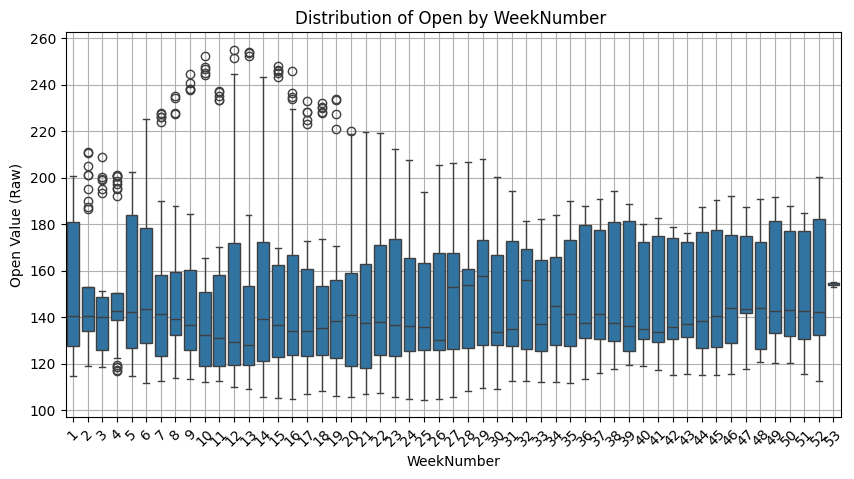


Outlier counts by WeekNumber:
{1: 0, 2: 9, 3: 6, 4: 14, 5: 0, 6: 0, 7: 5, 8: 4, 9: 5, 10: 5, 11: 5, 12: 2, 13: 3, 14: 0, 15: 5, 16: 4, 17: 5, 18: 5, 19: 4, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0}

Normalized outlier counts (outliers/C) by WeekNumber:
{1: 0.0, 2: 0.24324324324324326, 3: 0.2, 4: 0.3783783783783784, 5: 0.0, 6: 0.0, 7: 0.13157894736842105, 8: 0.125, 9: 0.1282051282051282, 10: 0.13513513513513514, 11: 0.1282051282051282, 12: 0.05555555555555555, 13: 0.09090909090909091, 14: 0.0, 15: 0.14285714285714285, 16: 0.10526315789473684, 17: 0.1282051282051282, 18: 0.13513513513513514, 19: 0.10810810810810811, 20: 0.02702702702702703, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38:

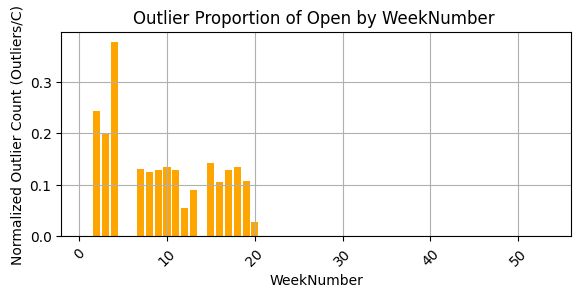


ANOVA Test Results for Open by WeekNumber:
F-statistic: 0.2304
p-value: 1.0000
No statistically significant difference in Open by WeekNumber.

Correlation between Open and WeekNumber:
Correlation coefficient: 0.0050
p-value: 0.8263
No statistically significant correlation between Open and WeekNumber.

=== Analyzing Open by DayOfWeek (Regulated: False) ===

Count of records by DayOfWeek (C):
DayOfWeek
0    348
1    394
2    394
3    387
4    378
Name: count, dtype: int64


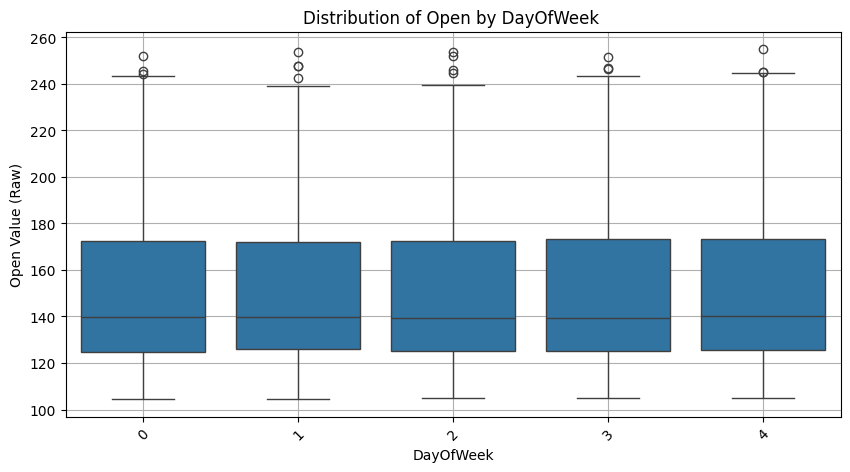


Outlier counts by DayOfWeek:
{0: 3, 1: 4, 2: 4, 3: 3, 4: 3}

Normalized outlier counts (outliers/C) by DayOfWeek:
{0: 0.008620689655172414, 1: 0.01015228426395939, 2: 0.01015228426395939, 3: 0.007751937984496124, 4: 0.007936507936507936}


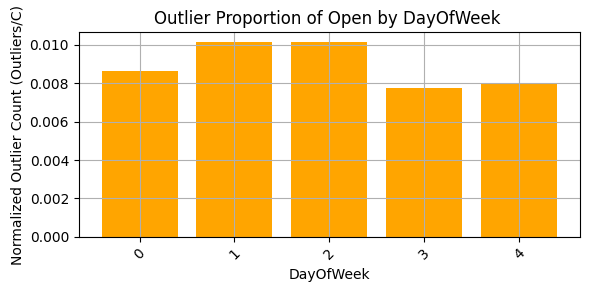


ANOVA Test Results for Open by DayOfWeek:
F-statistic: 0.0667
p-value: 0.9918
No statistically significant difference in Open by DayOfWeek.

Correlation between Open and DayOfWeek:
Correlation coefficient: 0.0064
p-value: 0.7811
No statistically significant correlation between Open and DayOfWeek.

=== Analyzing Open by WeekNoInMonth (Regulated: False) ===

Count of records by WeekNoInMonth (C):
WeekNoInMonth
1    429
2    453
3    433
4    438
5    148
Name: count, dtype: int64


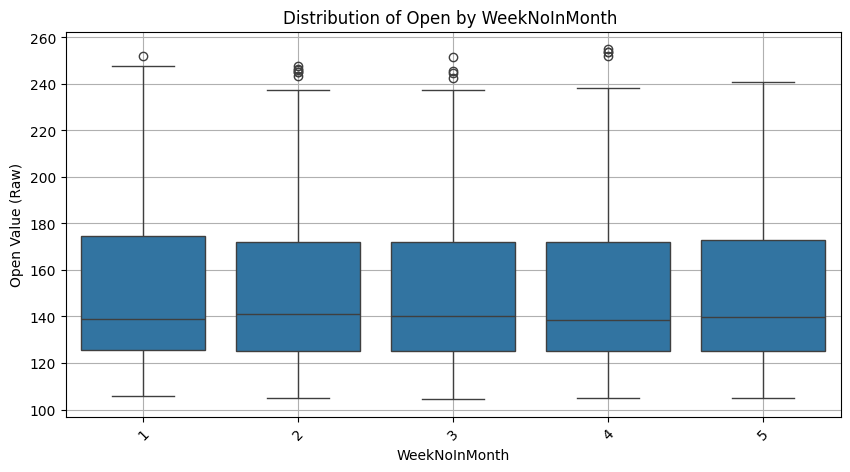


Outlier counts by WeekNoInMonth:
{1: 1, 2: 6, 3: 4, 4: 4, 5: 0}

Normalized outlier counts (outliers/C) by WeekNoInMonth:
{1: 0.002331002331002331, 2: 0.013245033112582781, 3: 0.009237875288683603, 4: 0.0091324200913242, 5: 0.0}


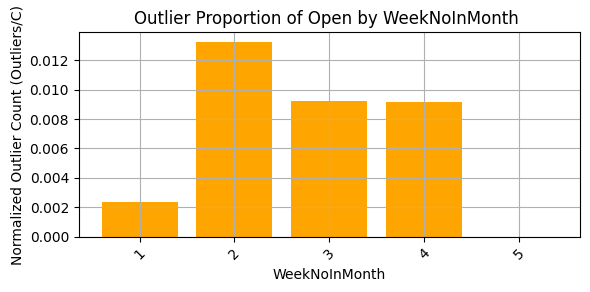


ANOVA Test Results for Open by WeekNoInMonth:
F-statistic: 0.0856
p-value: 0.9869
No statistically significant difference in Open by WeekNoInMonth.

Correlation between Open and WeekNoInMonth:
Correlation coefficient: -0.0127
p-value: 0.5798
No statistically significant correlation between Open and WeekNoInMonth.

=== Analyzing High by DayOfMonth (Regulated: False) ===

Count of records by DayOfMonth (C):
DayOfMonth
1     58
2     59
3     65
4     56
5     63
6     67
7     61
8     65
9     64
10    65
11    65
12    64
13    67
14    63
15    62
16    65
17    60
18    62
19    61
20    57
21    66
22    67
23    64
24    61
25    58
26    66
27    62
28    60
29    57
30    54
31    37
Name: count, dtype: int64


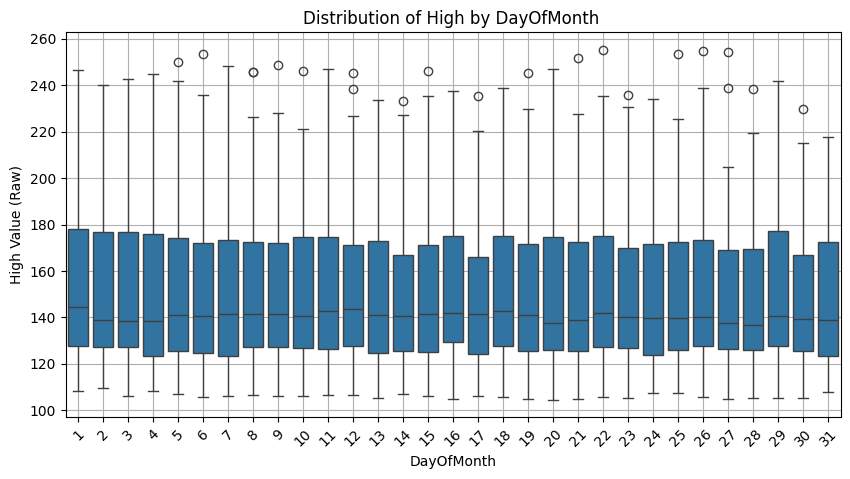


Outlier counts by DayOfMonth:
{1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 2, 9: 1, 10: 1, 11: 0, 12: 2, 13: 0, 14: 1, 15: 1, 16: 0, 17: 1, 18: 0, 19: 1, 20: 0, 21: 1, 22: 1, 23: 1, 24: 0, 25: 1, 26: 1, 27: 2, 28: 1, 29: 0, 30: 1, 31: 0}

Normalized outlier counts (outliers/C) by DayOfMonth:
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.015873015873015872, 6: 0.014925373134328358, 7: 0.0, 8: 0.03076923076923077, 9: 0.015625, 10: 0.015384615384615385, 11: 0.0, 12: 0.03125, 13: 0.0, 14: 0.015873015873015872, 15: 0.016129032258064516, 16: 0.0, 17: 0.016666666666666666, 18: 0.0, 19: 0.01639344262295082, 20: 0.0, 21: 0.015151515151515152, 22: 0.014925373134328358, 23: 0.015625, 24: 0.0, 25: 0.017241379310344827, 26: 0.015151515151515152, 27: 0.03225806451612903, 28: 0.016666666666666666, 29: 0.0, 30: 0.018518518518518517, 31: 0.0}


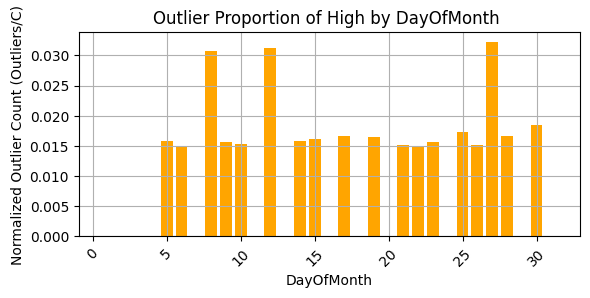


ANOVA Test Results for High by DayOfMonth:
F-statistic: 0.1704
p-value: 1.0000
No statistically significant difference in High by DayOfMonth.

Correlation between High and DayOfMonth:
Correlation coefficient: -0.0204
p-value: 0.3737
No statistically significant correlation between High and DayOfMonth.

=== Analyzing High by WeekNumber (Regulated: False) ===

Count of records by WeekNumber (C):
WeekNumber
1     33
2     37
3     30
4     37
5     38
6     39
7     38
8     32
9     39
10    37
11    39
12    36
13    33
14    35
15    35
16    38
17    39
18    37
19    37
20    37
21    38
22    30
23    39
24    38
25    36
26    39
27    31
28    37
29    38
30    38
31    39
32    37
33    35
34    40
35    38
36    32
37    35
38    39
39    37
40    39
41    40
42    37
43    39
44    34
45    37
46    38
47    34
48    34
49    36
50    39
51    38
52    31
53     3
Name: count, dtype: Int64


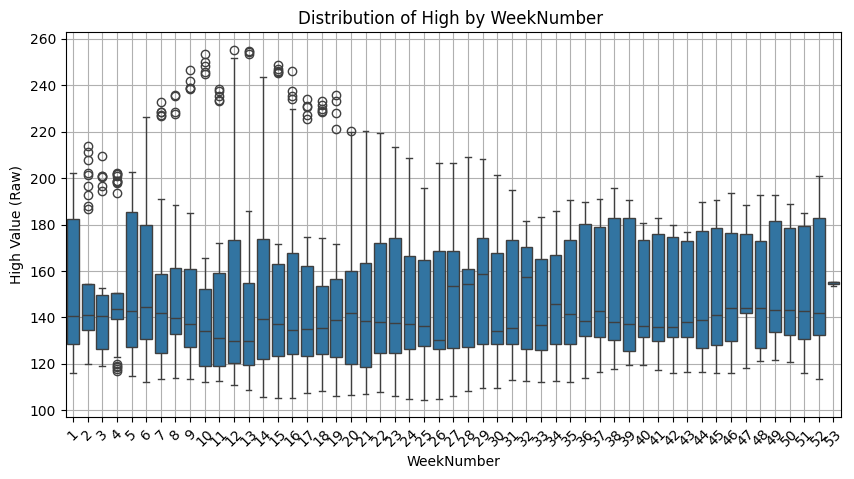


Outlier counts by WeekNumber:
{1: 0, 2: 9, 3: 6, 4: 14, 5: 0, 6: 0, 7: 5, 8: 4, 9: 5, 10: 5, 11: 5, 12: 1, 13: 3, 14: 0, 15: 5, 16: 4, 17: 5, 18: 5, 19: 4, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0}

Normalized outlier counts (outliers/C) by WeekNumber:
{1: 0.0, 2: 0.24324324324324326, 3: 0.2, 4: 0.3783783783783784, 5: 0.0, 6: 0.0, 7: 0.13157894736842105, 8: 0.125, 9: 0.1282051282051282, 10: 0.13513513513513514, 11: 0.1282051282051282, 12: 0.027777777777777776, 13: 0.09090909090909091, 14: 0.0, 15: 0.14285714285714285, 16: 0.10526315789473684, 17: 0.1282051282051282, 18: 0.13513513513513514, 19: 0.10810810810810811, 20: 0.02702702702702703, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 0.0, 37: 0.0, 38

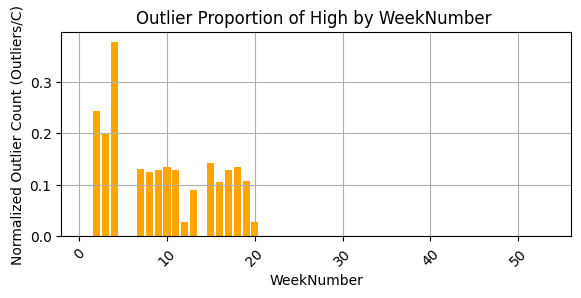


ANOVA Test Results for High by WeekNumber:
F-statistic: 0.2353
p-value: 1.0000
No statistically significant difference in High by WeekNumber.

Correlation between High and WeekNumber:
Correlation coefficient: 0.0044
p-value: 0.8481
No statistically significant correlation between High and WeekNumber.

=== Analyzing High by DayOfWeek (Regulated: False) ===

Count of records by DayOfWeek (C):
DayOfWeek
0    348
1    394
2    394
3    387
4    378
Name: count, dtype: int64


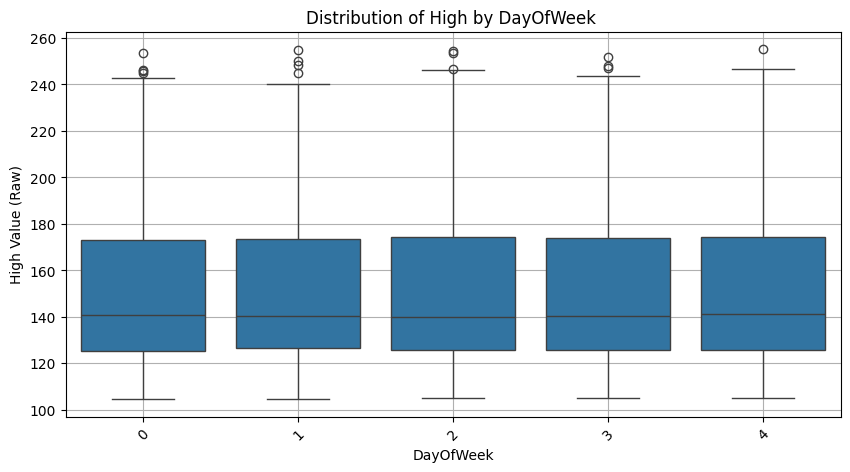


Outlier counts by DayOfWeek:
{0: 4, 1: 4, 2: 3, 3: 3, 4: 1}

Normalized outlier counts (outliers/C) by DayOfWeek:
{0: 0.011494252873563218, 1: 0.01015228426395939, 2: 0.007614213197969543, 3: 0.007751937984496124, 4: 0.0026455026455026454}


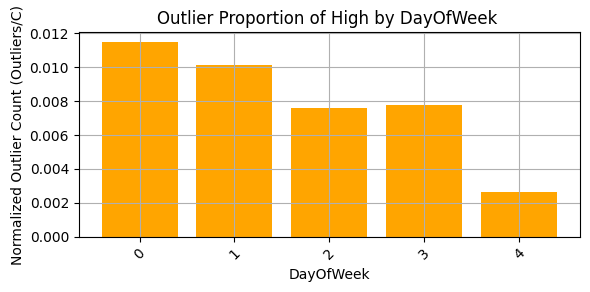


ANOVA Test Results for High by DayOfWeek:
F-statistic: 0.0611
p-value: 0.9931
No statistically significant difference in High by DayOfWeek.

Correlation between High and DayOfWeek:
Correlation coefficient: 0.0055
p-value: 0.8093
No statistically significant correlation between High and DayOfWeek.

=== Analyzing High by WeekNoInMonth (Regulated: False) ===

Count of records by WeekNoInMonth (C):
WeekNoInMonth
1    429
2    453
3    433
4    438
5    148
Name: count, dtype: int64


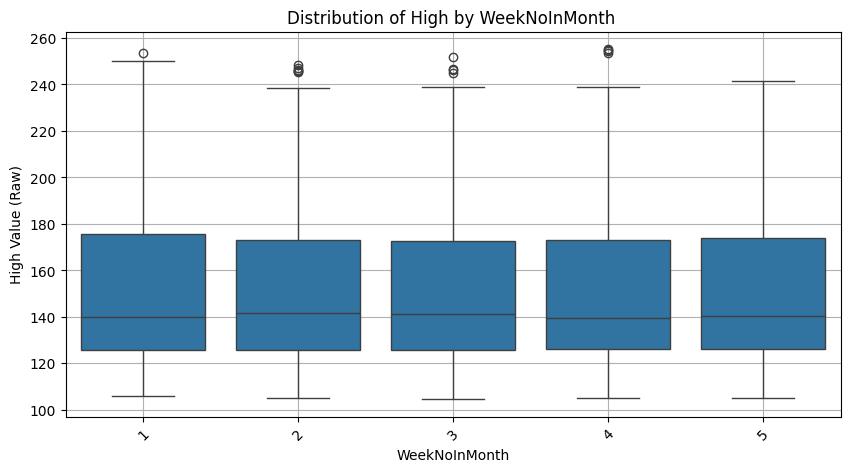


Outlier counts by WeekNoInMonth:
{1: 1, 2: 6, 3: 4, 4: 4, 5: 0}

Normalized outlier counts (outliers/C) by WeekNoInMonth:
{1: 0.002331002331002331, 2: 0.013245033112582781, 3: 0.009237875288683603, 4: 0.0091324200913242, 5: 0.0}


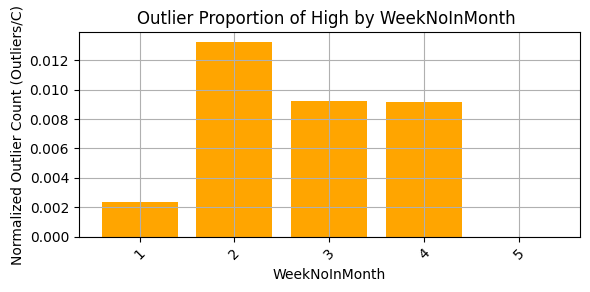


ANOVA Test Results for High by WeekNoInMonth:
F-statistic: 0.1152
p-value: 0.9772
No statistically significant difference in High by WeekNoInMonth.

Correlation between High and WeekNoInMonth:
Correlation coefficient: -0.0146
p-value: 0.5260
No statistically significant correlation between High and WeekNoInMonth.

=== Analyzing Volume by DayOfMonth (Regulated: False) ===

Count of records by DayOfMonth (C):
DayOfMonth
1     58
2     59
3     65
4     56
5     63
6     67
7     61
8     65
9     64
10    65
11    65
12    64
13    67
14    63
15    62
16    65
17    60
18    62
19    61
20    57
21    66
22    67
23    64
24    61
25    58
26    66
27    62
28    60
29    57
30    54
31    37
Name: count, dtype: int64


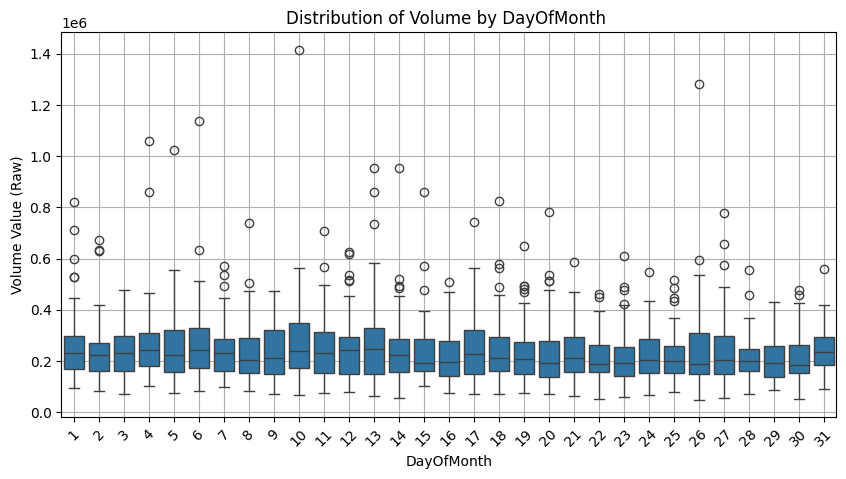


Outlier counts by DayOfMonth:
{1: 5, 2: 3, 3: 0, 4: 2, 5: 1, 6: 2, 7: 3, 8: 2, 9: 0, 10: 1, 11: 2, 12: 5, 13: 3, 14: 4, 15: 3, 16: 1, 17: 1, 18: 4, 19: 5, 20: 4, 21: 1, 22: 2, 23: 4, 24: 1, 25: 4, 26: 2, 27: 3, 28: 2, 29: 0, 30: 2, 31: 1}

Normalized outlier counts (outliers/C) by DayOfMonth:
{1: 0.08620689655172414, 2: 0.05084745762711865, 3: 0.0, 4: 0.03571428571428571, 5: 0.015873015873015872, 6: 0.029850746268656716, 7: 0.04918032786885246, 8: 0.03076923076923077, 9: 0.0, 10: 0.015384615384615385, 11: 0.03076923076923077, 12: 0.078125, 13: 0.04477611940298507, 14: 0.06349206349206349, 15: 0.04838709677419355, 16: 0.015384615384615385, 17: 0.016666666666666666, 18: 0.06451612903225806, 19: 0.08196721311475409, 20: 0.07017543859649122, 21: 0.015151515151515152, 22: 0.029850746268656716, 23: 0.0625, 24: 0.01639344262295082, 25: 0.06896551724137931, 26: 0.030303030303030304, 27: 0.04838709677419355, 28: 0.03333333333333333, 29: 0.0, 30: 0.037037037037037035, 31: 0.02702702702702703}


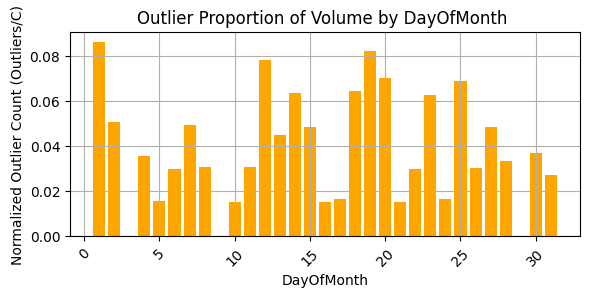


ANOVA Test Results for Volume by DayOfMonth:
F-statistic: 1.2840
p-value: 0.1394
No statistically significant difference in Volume by DayOfMonth.

Correlation between Volume and DayOfMonth:
Correlation coefficient: -0.0876
p-value: 0.0001
Statistically significant correlation between Volume and DayOfMonth.

=== Analyzing Volume by WeekNumber (Regulated: False) ===

Count of records by WeekNumber (C):
WeekNumber
1     33
2     37
3     30
4     37
5     38
6     39
7     38
8     32
9     39
10    37
11    39
12    36
13    33
14    35
15    35
16    38
17    39
18    37
19    37
20    37
21    38
22    30
23    39
24    38
25    36
26    39
27    31
28    37
29    38
30    38
31    39
32    37
33    35
34    40
35    38
36    32
37    35
38    39
39    37
40    39
41    40
42    37
43    39
44    34
45    37
46    38
47    34
48    34
49    36
50    39
51    38
52    31
53     3
Name: count, dtype: Int64


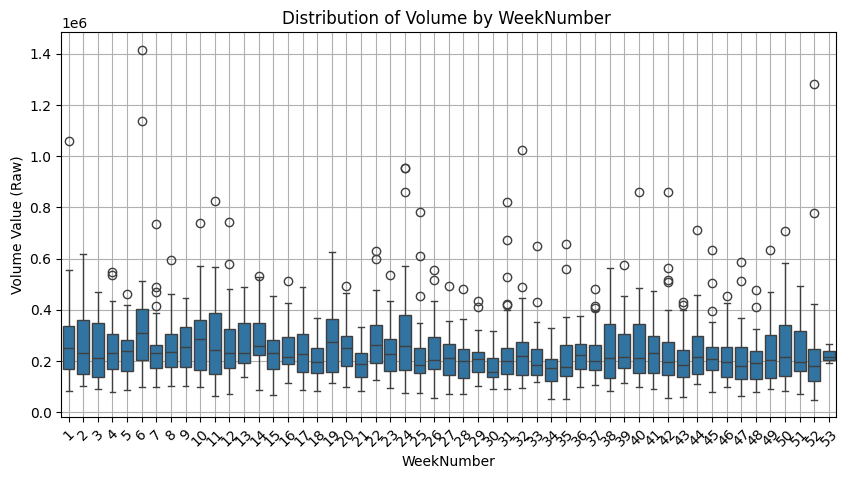


Outlier counts by WeekNumber:
{1: 1, 2: 0, 3: 0, 4: 2, 5: 1, 6: 2, 7: 4, 8: 1, 9: 0, 10: 1, 11: 1, 12: 2, 13: 0, 14: 1, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0, 20: 1, 21: 0, 22: 2, 23: 1, 24: 3, 25: 3, 26: 2, 27: 1, 28: 1, 29: 2, 30: 0, 31: 5, 32: 2, 33: 2, 34: 0, 35: 2, 36: 0, 37: 3, 38: 0, 39: 1, 40: 1, 41: 0, 42: 4, 43: 2, 44: 1, 45: 3, 46: 1, 47: 2, 48: 2, 49: 1, 50: 1, 51: 0, 52: 2, 53: 0}

Normalized outlier counts (outliers/C) by WeekNumber:
{1: 0.030303030303030304, 2: 0.0, 3: 0.0, 4: 0.05405405405405406, 5: 0.02631578947368421, 6: 0.05128205128205128, 7: 0.10526315789473684, 8: 0.03125, 9: 0.0, 10: 0.02702702702702703, 11: 0.02564102564102564, 12: 0.05555555555555555, 13: 0.0, 14: 0.02857142857142857, 15: 0.0, 16: 0.02631578947368421, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.02702702702702703, 21: 0.0, 22: 0.06666666666666667, 23: 0.02564102564102564, 24: 0.07894736842105263, 25: 0.08333333333333333, 26: 0.05128205128205128, 27: 0.03225806451612903, 28: 0.02702702702702703, 29: 0.05263157

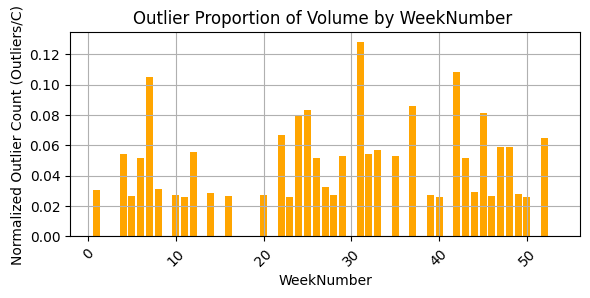


ANOVA Test Results for Volume by WeekNumber:
F-statistic: 2.4152
p-value: 0.0000
Statistically significant difference in Volume by WeekNumber.

Correlation between Volume and WeekNumber:
Correlation coefficient: -0.1067
p-value: 0.0000
Statistically significant correlation between Volume and WeekNumber.

=== Analyzing Volume by DayOfWeek (Regulated: False) ===

Count of records by DayOfWeek (C):
DayOfWeek
0    348
1    394
2    394
3    387
4    378
Name: count, dtype: int64


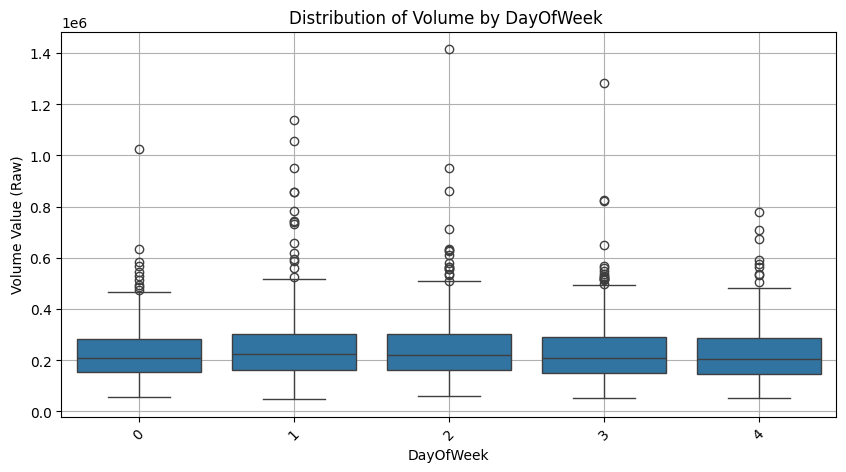


Outlier counts by DayOfWeek:
{0: 10, 1: 15, 2: 16, 3: 15, 4: 9}

Normalized outlier counts (outliers/C) by DayOfWeek:
{0: 0.028735632183908046, 1: 0.03807106598984772, 2: 0.04060913705583756, 3: 0.03875968992248062, 4: 0.023809523809523808}


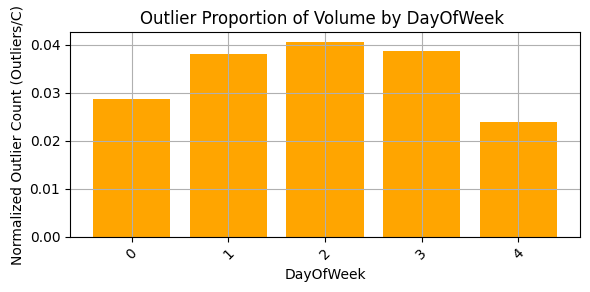


ANOVA Test Results for Volume by DayOfWeek:
F-statistic: 3.2417
p-value: 0.0116
Statistically significant difference in Volume by DayOfWeek.

Correlation between Volume and DayOfWeek:
Correlation coefficient: -0.0294
p-value: 0.2004
No statistically significant correlation between Volume and DayOfWeek.

=== Analyzing Volume by WeekNoInMonth (Regulated: False) ===

Count of records by WeekNoInMonth (C):
WeekNoInMonth
1    429
2    453
3    433
4    438
5    148
Name: count, dtype: int64


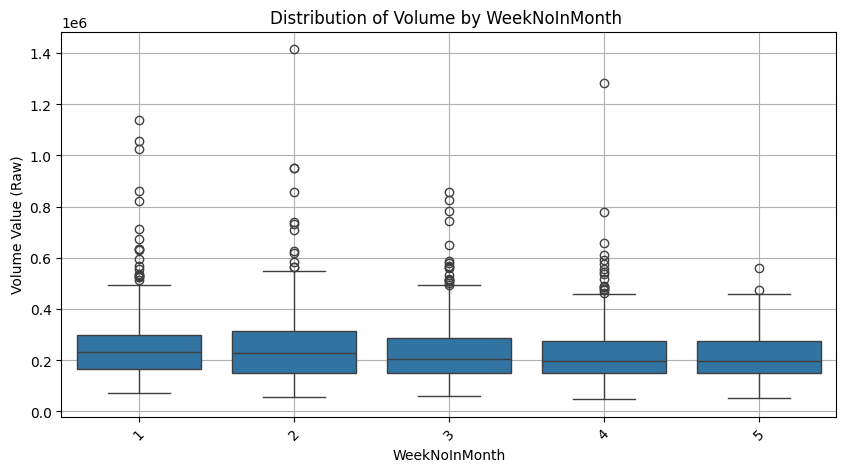


Outlier counts by WeekNoInMonth:
{1: 19, 2: 12, 3: 17, 4: 16, 5: 2}

Normalized outlier counts (outliers/C) by WeekNoInMonth:
{1: 0.04428904428904429, 2: 0.026490066225165563, 3: 0.03926096997690531, 4: 0.0365296803652968, 5: 0.013513513513513514}


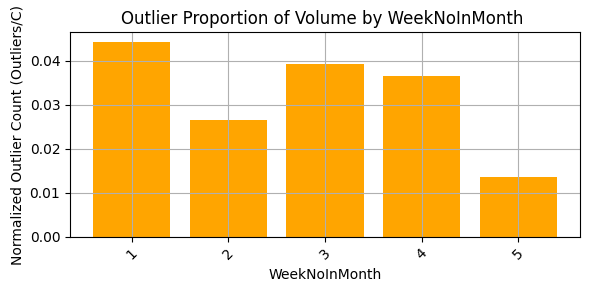


ANOVA Test Results for Volume by WeekNoInMonth:
F-statistic: 4.6440
p-value: 0.0010
Statistically significant difference in Volume by WeekNoInMonth.

Correlation between Volume and WeekNoInMonth:
Correlation coefficient: -0.0935
p-value: 0.0000
Statistically significant correlation between Volume and WeekNoInMonth.


In [47]:
test_all_combinations(df, date_column='Date', regulateOn=False)



=== Analyzing Open with Lagged transformation ===


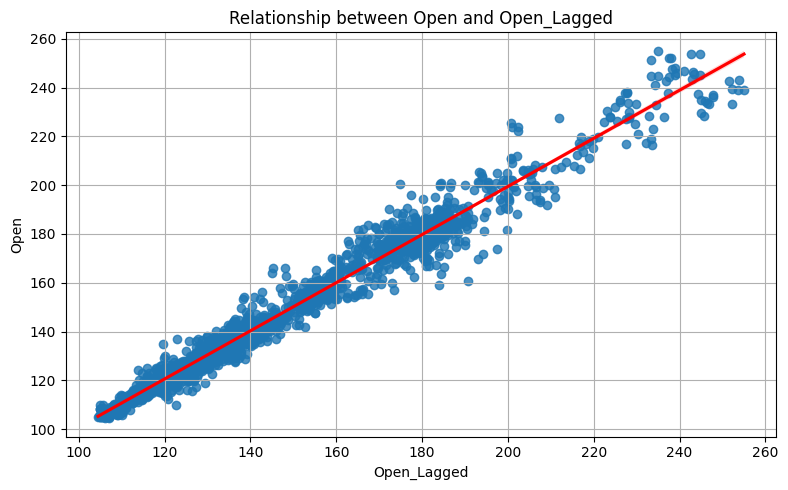


Correlation between Open and Open_Lagged:
Correlation coefficient: 0.9852
p-value: 0.0000
Statistically significant correlation between Open and Open_Lagged.


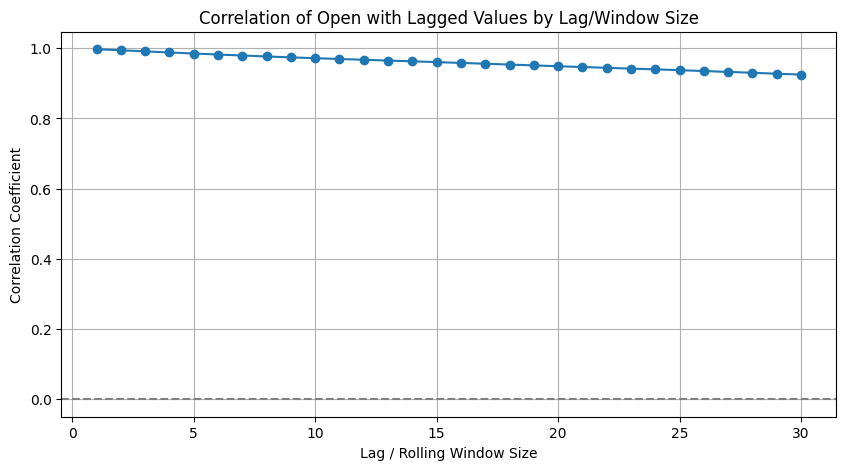


Correlation by Lag/Window Size:
Lag/Window Size 1: Correlation = 0.9974
Lag/Window Size 2: Correlation = 0.9944
Lag/Window Size 3: Correlation = 0.9913
Lag/Window Size 4: Correlation = 0.9882
Lag/Window Size 5: Correlation = 0.9852
Lag/Window Size 6: Correlation = 0.9823
Lag/Window Size 7: Correlation = 0.9795
Lag/Window Size 8: Correlation = 0.9767
Lag/Window Size 9: Correlation = 0.9742
Lag/Window Size 10: Correlation = 0.9719
Lag/Window Size 11: Correlation = 0.9696
Lag/Window Size 12: Correlation = 0.9673
Lag/Window Size 13: Correlation = 0.9651
Lag/Window Size 14: Correlation = 0.9629
Lag/Window Size 15: Correlation = 0.9607
Lag/Window Size 16: Correlation = 0.9583
Lag/Window Size 17: Correlation = 0.9561
Lag/Window Size 18: Correlation = 0.9537
Lag/Window Size 19: Correlation = 0.9514
Lag/Window Size 20: Correlation = 0.9489
Lag/Window Size 21: Correlation = 0.9467
Lag/Window Size 22: Correlation = 0.9444
Lag/Window Size 23: Correlation = 0.9421
Lag/Window Size 24: Correlation =

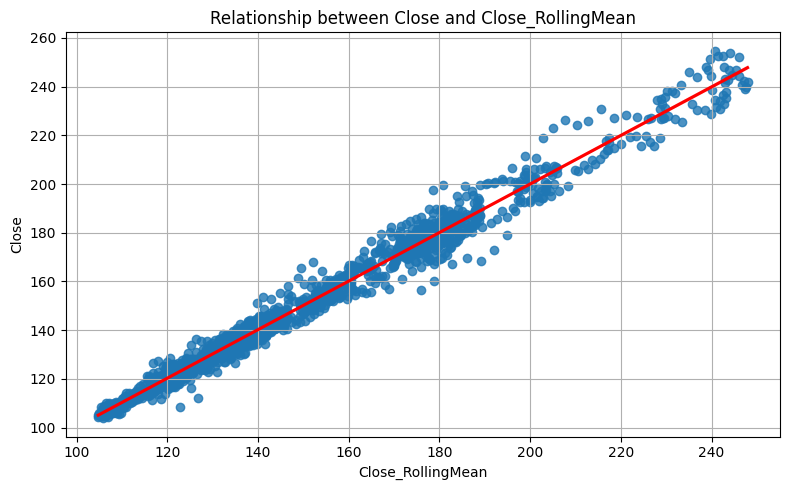


Correlation between Close and Close_RollingMean:
Correlation coefficient: 0.9916
p-value: 0.0000
Statistically significant correlation between Close and Close_RollingMean.


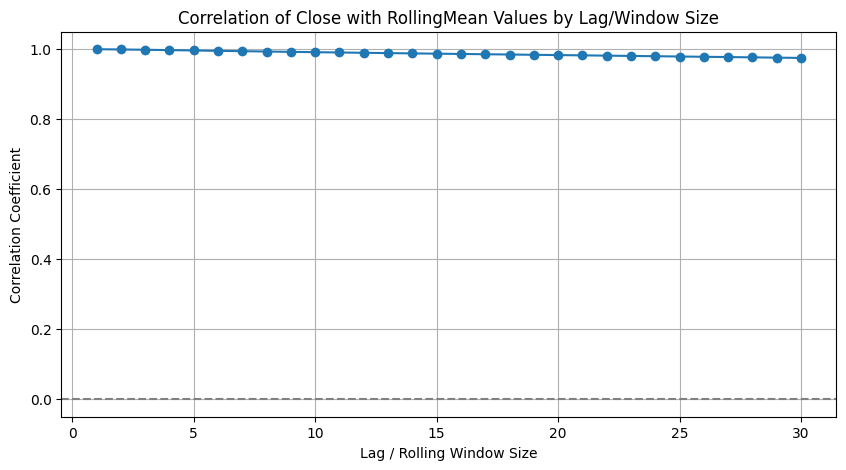


Correlation by Lag/Window Size:
Lag/Window Size 1: Correlation = 1.0000
Lag/Window Size 2: Correlation = 0.9993
Lag/Window Size 3: Correlation = 0.9984
Lag/Window Size 4: Correlation = 0.9974
Lag/Window Size 5: Correlation = 0.9964
Lag/Window Size 6: Correlation = 0.9954
Lag/Window Size 7: Correlation = 0.9944
Lag/Window Size 8: Correlation = 0.9934
Lag/Window Size 9: Correlation = 0.9925
Lag/Window Size 10: Correlation = 0.9916
Lag/Window Size 11: Correlation = 0.9907
Lag/Window Size 12: Correlation = 0.9898
Lag/Window Size 13: Correlation = 0.9889
Lag/Window Size 14: Correlation = 0.9881
Lag/Window Size 15: Correlation = 0.9873
Lag/Window Size 16: Correlation = 0.9865
Lag/Window Size 17: Correlation = 0.9857
Lag/Window Size 18: Correlation = 0.9849
Lag/Window Size 19: Correlation = 0.9841
Lag/Window Size 20: Correlation = 0.9833
Lag/Window Size 21: Correlation = 0.9824
Lag/Window Size 22: Correlation = 0.9816
Lag/Window Size 23: Correlation = 0.9808
Lag/Window Size 24: Correlation =

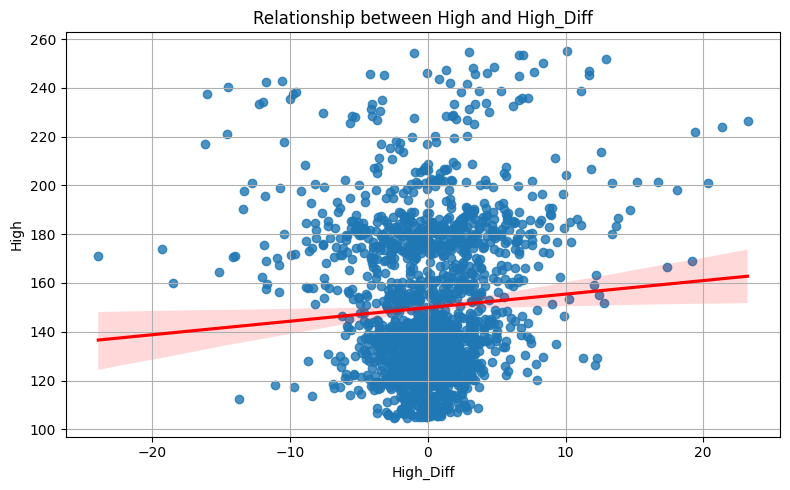


Correlation between High and High_Diff:
Correlation coefficient: 0.0718
p-value: 0.0017
Statistically significant correlation between High and High_Diff.

=== Analyzing Low with PctChange transformation ===


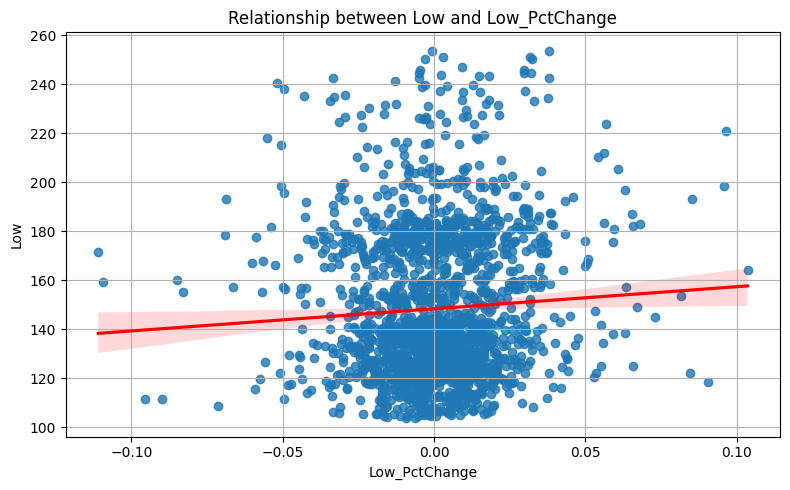


Correlation between Low and Low_PctChange:
Correlation coefficient: 0.0602
p-value: 0.0087
Statistically significant correlation between Low and Low_PctChange.

=== Analyzing Volume with RollingMedian transformation ===


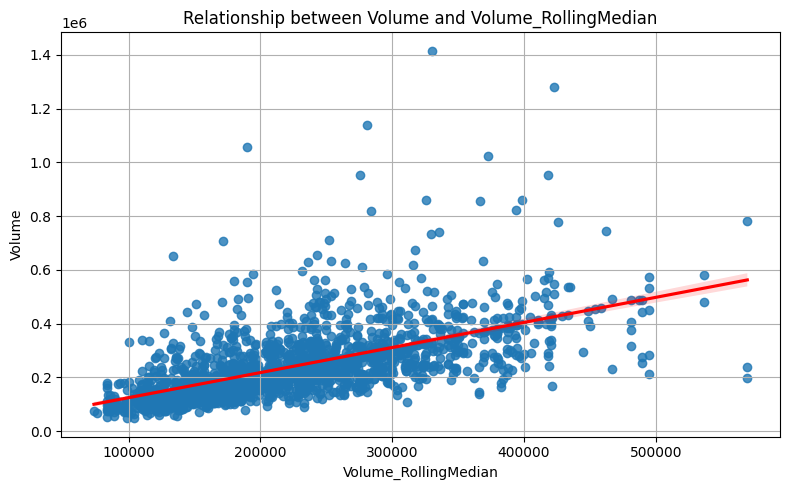


Correlation between Volume and Volume_RollingMedian:
Correlation coefficient: 0.6168
p-value: 0.0000
Statistically significant correlation between Volume and Volume_RollingMedian.


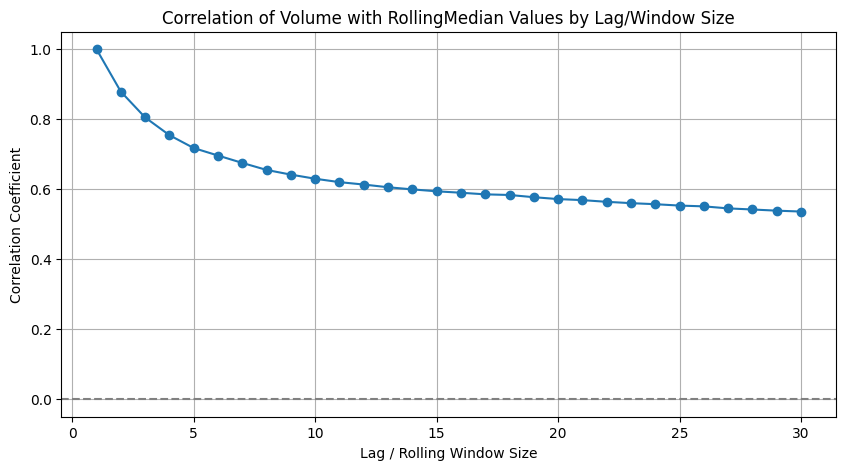


Correlation by Lag/Window Size:
Lag/Window Size 1: Correlation = 1.0000
Lag/Window Size 2: Correlation = 0.8789
Lag/Window Size 3: Correlation = 0.8052
Lag/Window Size 4: Correlation = 0.7545
Lag/Window Size 5: Correlation = 0.7177
Lag/Window Size 6: Correlation = 0.6963
Lag/Window Size 7: Correlation = 0.6752
Lag/Window Size 8: Correlation = 0.6551
Lag/Window Size 9: Correlation = 0.6417
Lag/Window Size 10: Correlation = 0.6300
Lag/Window Size 11: Correlation = 0.6202
Lag/Window Size 12: Correlation = 0.6134
Lag/Window Size 13: Correlation = 0.6056
Lag/Window Size 14: Correlation = 0.5995
Lag/Window Size 15: Correlation = 0.5941
Lag/Window Size 16: Correlation = 0.5900
Lag/Window Size 17: Correlation = 0.5854
Lag/Window Size 18: Correlation = 0.5836
Lag/Window Size 19: Correlation = 0.5772
Lag/Window Size 20: Correlation = 0.5719
Lag/Window Size 21: Correlation = 0.5689
Lag/Window Size 22: Correlation = 0.5640
Lag/Window Size 23: Correlation = 0.5602
Lag/Window Size 24: Correlation =

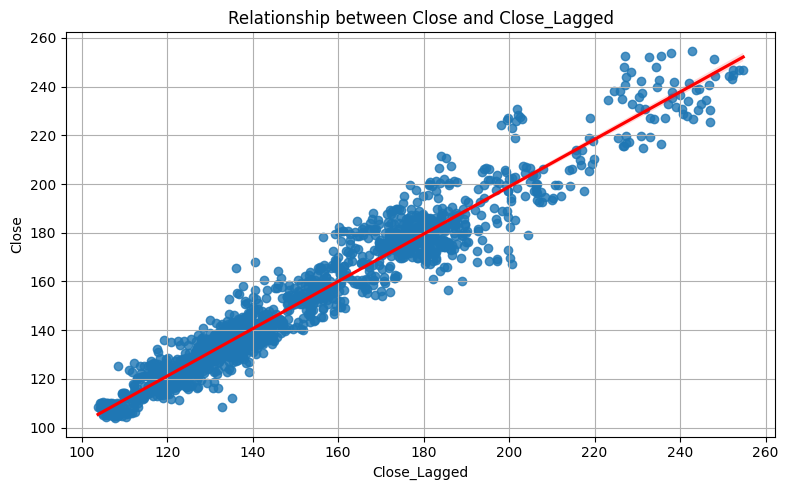


Correlation between Close and Close_Lagged:
Correlation coefficient: 0.9719
p-value: 0.0000
Statistically significant correlation between Close and Close_Lagged.


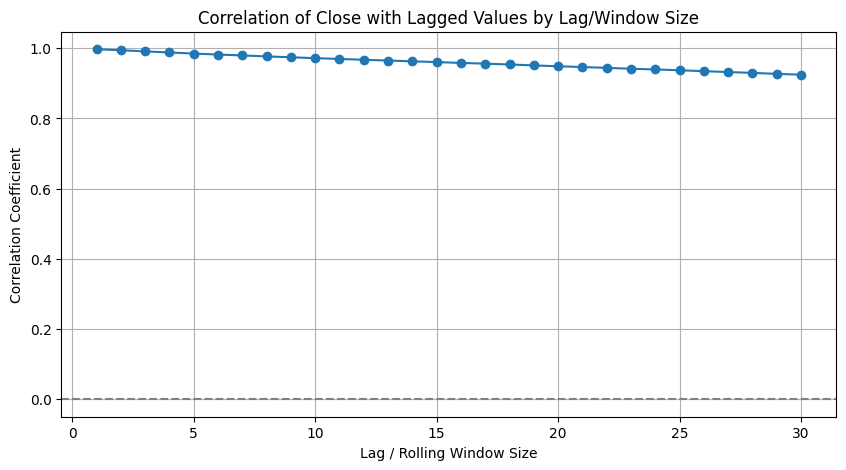


Correlation by Lag/Window Size:
Lag/Window Size 1: Correlation = 0.9972
Lag/Window Size 2: Correlation = 0.9943
Lag/Window Size 3: Correlation = 0.9911
Lag/Window Size 4: Correlation = 0.9879
Lag/Window Size 5: Correlation = 0.9848
Lag/Window Size 6: Correlation = 0.9821
Lag/Window Size 7: Correlation = 0.9794
Lag/Window Size 8: Correlation = 0.9767
Lag/Window Size 9: Correlation = 0.9742
Lag/Window Size 10: Correlation = 0.9717
Lag/Window Size 11: Correlation = 0.9694
Lag/Window Size 12: Correlation = 0.9672
Lag/Window Size 13: Correlation = 0.9649
Lag/Window Size 14: Correlation = 0.9628
Lag/Window Size 15: Correlation = 0.9605
Lag/Window Size 16: Correlation = 0.9582
Lag/Window Size 17: Correlation = 0.9561
Lag/Window Size 18: Correlation = 0.9537
Lag/Window Size 19: Correlation = 0.9511
Lag/Window Size 20: Correlation = 0.9486
Lag/Window Size 21: Correlation = 0.9464
Lag/Window Size 22: Correlation = 0.9441
Lag/Window Size 23: Correlation = 0.9416
Lag/Window Size 24: Correlation =

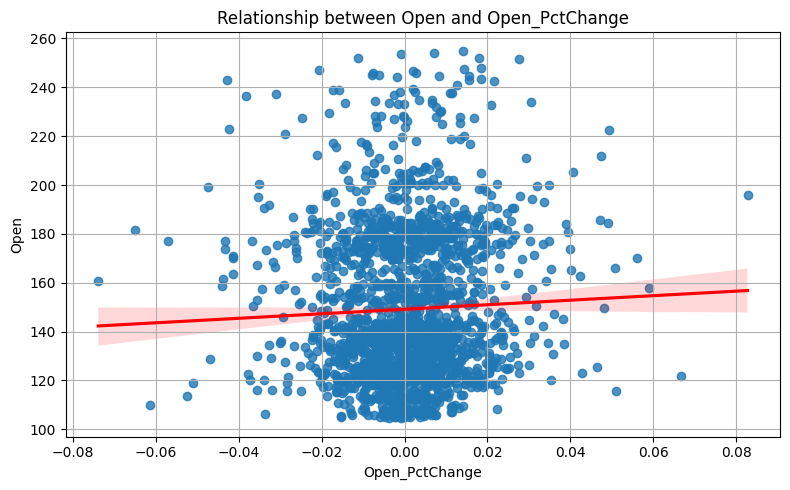


Correlation between Open and Open_PctChange:
Correlation coefficient: 0.0415
p-value: 0.0706
No statistically significant correlation between Open and Open_PctChange.


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_x_with_transformed_y(
    df,
    x_column='Open',
    y_transform='Lagged',
    lag=1,
    window=5,
    date_column='Date'
):
    """
    Analyzes the relationship between a stock metric (x) and its transformed values (y).
    Transformed values can include lagged values, rolling means, and more.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the stock data.
    x_column : str, default 'Open'
        The column to analyze ('Open', 'Close', 'High', 'Low', 'Volume').
    y_transform : str, default 'Lagged'
        The transformation to apply to the x column ('Lagged', 'RollingMean', 'RollingMedian', 'Diff', 'PctChange').
    lag : int, default 1
        The number of periods to lag (applicable if y_transform='Lagged' or 'Diff').
    window : int, default 5
        The window size for rolling calculations (applicable if y_transform is 'RollingMean' or 'RollingMedian').
    date_column : str, default 'Date'
        The date column used for sorting the data.

    Returns:
    --------
    None
    """

    # Ensure data is sorted by date
    df = df.sort_values(by=date_column)

    # Generate the transformed y_column based on the specified method
    y_column = f'{x_column}_{y_transform}'

    if y_transform == 'Lagged':
        df[y_column] = df[x_column].shift(lag)
    elif y_transform == 'RollingMean':
        df[y_column] = df[x_column].rolling(window=window).mean()
    elif y_transform == 'RollingMedian':
        df[y_column] = df[x_column].rolling(window=window).median()
    elif y_transform == 'Diff':
        df[y_column] = df[x_column].diff(lag)
    elif y_transform == 'PctChange':
        df[y_column] = df[x_column].pct_change(periods=lag)
    else:
        raise ValueError(f"Unsupported y_transform: {y_transform}")

    # Drop rows with NaN values resulting from transformations
    df = df.dropna(subset=[x_column, y_column])

    # 1. Scatter Plot with Regression Line
    plt.figure(figsize=(8, 5))
    sns.regplot(x=y_column, y=x_column, data=df, line_kws={"color": "red"})
    plt.xlabel(y_column)
    plt.ylabel(x_column)
    plt.title(f'Relationship between {x_column} and {y_column}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. Calculate and Display Correlation
    correlation, p_value = stats.pearsonr(df[y_column], df[x_column])
    print(f"\nCorrelation between {x_column} and {y_column}:")
    print(f"Correlation coefficient: {correlation:.4f}")
    print(f"p-value: {p_value:.4f}")

    if p_value < 0.05:
        print(f"Statistically significant correlation between {x_column} and {y_column}.")
    else:
        print(f"No statistically significant correlation between {x_column} and {y_column}.")

    # 3. Heatmap of Correlation if Rolling or Lagged
    if y_transform in ['Lagged', 'RollingMean', 'RollingMedian']:
        max_lag = 30  # Example: Check up to 30 lags/rolling windows
        correlations = []
        lags = range(1, max_lag + 1)

        for lag in lags:
            if y_transform == 'Lagged':
                df[f'{y_column}_lag{lag}'] = df[x_column].shift(lag)
            elif y_transform in ['RollingMean', 'RollingMedian']:
                df[f'{y_column}_lag{lag}'] = df[x_column].rolling(window=lag).mean()

            corr = df[x_column].corr(df[f'{y_column}_lag{lag}'])
            correlations.append(corr)

        plt.figure(figsize=(10, 5))
        plt.plot(lags, correlations, marker='o')
        plt.xlabel('Lag / Rolling Window Size')
        plt.ylabel('Correlation Coefficient')
        plt.title(f'Correlation of {x_column} with {y_transform} Values by Lag/Window Size')
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.grid(True)
        plt.show()

        print("\nCorrelation by Lag/Window Size:")
        for lag, corr in zip(lags, correlations):
            print(f"Lag/Window Size {lag}: Correlation = {corr:.4f}")


# Define the configurations as a list of dictionaries
configurations = [
    {'x_column': 'Open', 'y_transform': 'Lagged', 'lag': 5},
    {'x_column': 'Close', 'y_transform': 'RollingMean', 'window': 10},
    {'x_column': 'High', 'y_transform': 'Diff', 'lag': 3},
    {'x_column': 'Low', 'y_transform': 'PctChange', 'lag': 2},
    {'x_column': 'Volume', 'y_transform': 'RollingMedian', 'window': 7},
    {'x_column': 'Close', 'y_transform': 'Lagged', 'lag': 10},
    {'x_column': 'Open', 'y_transform': 'PctChange', 'lag': 1}
]

# Iterate over configurations and run the analysis function
for config in configurations:
    print(f"\n=== Analyzing {config['x_column']} with {config['y_transform']} transformation ===")
    try:
        analyze_x_with_transformed_y(
            df,
            x_column=config['x_column'],
            y_transform=config['y_transform'],
            lag=config.get('lag', 1),
            window=config.get('window', 5),
            date_column='Date'
        )
    except Exception as e:
        print(f"Error while processing {config}: {e}")



=== Analyzing Close with Lagged(Volume) transformation ===


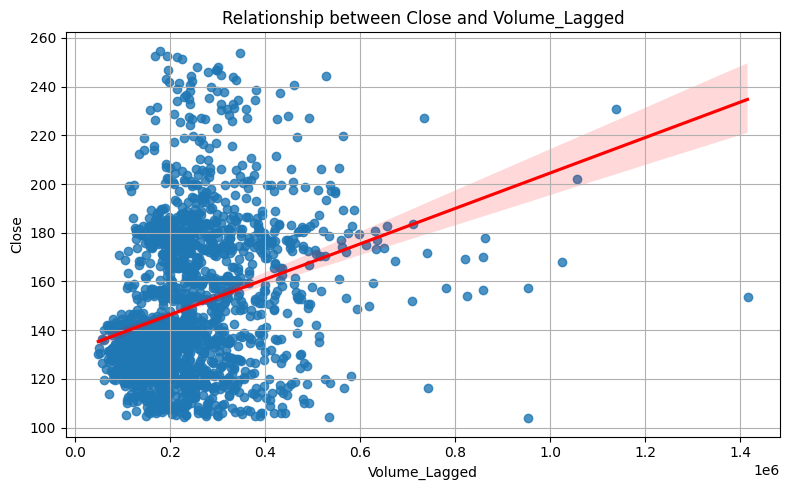


Correlation between Close and Volume_Lagged:
Correlation coefficient: 0.2972
p-value: 0.0000
Statistically significant correlation between Close and Volume_Lagged.


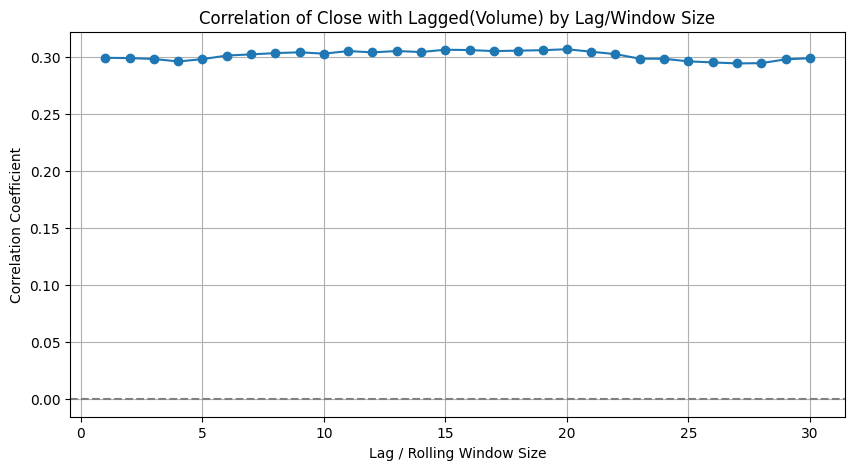


Correlation by Lag/Window Size:
Lag/Window Size 1: Correlation = 0.2996
Lag/Window Size 2: Correlation = 0.2994
Lag/Window Size 3: Correlation = 0.2986
Lag/Window Size 4: Correlation = 0.2964
Lag/Window Size 5: Correlation = 0.2984
Lag/Window Size 6: Correlation = 0.3016
Lag/Window Size 7: Correlation = 0.3026
Lag/Window Size 8: Correlation = 0.3038
Lag/Window Size 9: Correlation = 0.3045
Lag/Window Size 10: Correlation = 0.3033
Lag/Window Size 11: Correlation = 0.3056
Lag/Window Size 12: Correlation = 0.3044
Lag/Window Size 13: Correlation = 0.3056
Lag/Window Size 14: Correlation = 0.3047
Lag/Window Size 15: Correlation = 0.3067
Lag/Window Size 16: Correlation = 0.3064
Lag/Window Size 17: Correlation = 0.3055
Lag/Window Size 18: Correlation = 0.3059
Lag/Window Size 19: Correlation = 0.3063
Lag/Window Size 20: Correlation = 0.3072
Lag/Window Size 21: Correlation = 0.3050
Lag/Window Size 22: Correlation = 0.3029
Lag/Window Size 23: Correlation = 0.2989
Lag/Window Size 24: Correlation =

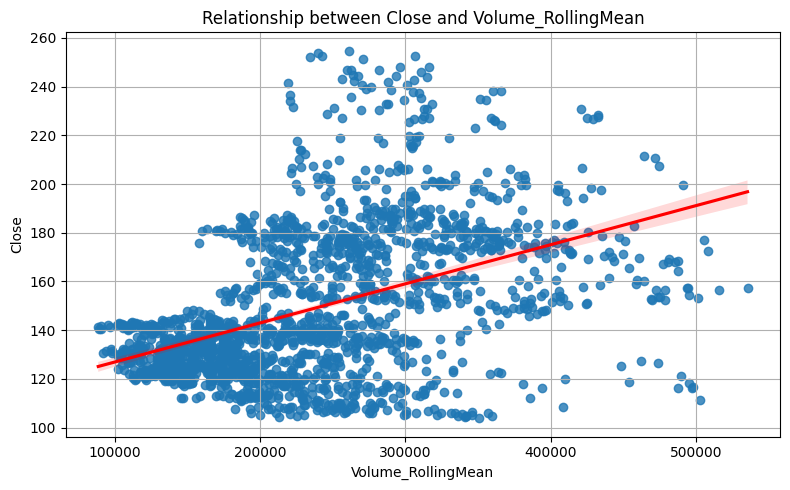


Correlation between Close and Volume_RollingMean:
Correlation coefficient: 0.4446
p-value: 0.0000
Statistically significant correlation between Close and Volume_RollingMean.


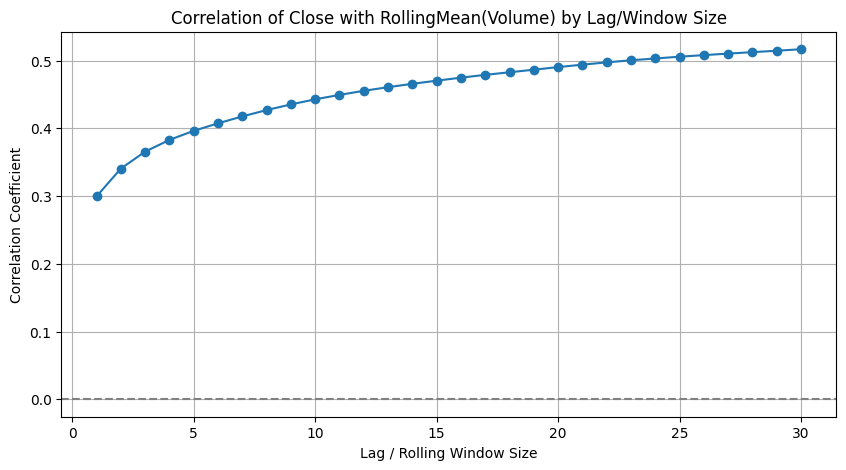


Correlation by Lag/Window Size:
Lag/Window Size 1: Correlation = 0.2994
Lag/Window Size 2: Correlation = 0.3405
Lag/Window Size 3: Correlation = 0.3656
Lag/Window Size 4: Correlation = 0.3829
Lag/Window Size 5: Correlation = 0.3963
Lag/Window Size 6: Correlation = 0.4074
Lag/Window Size 7: Correlation = 0.4176
Lag/Window Size 8: Correlation = 0.4270
Lag/Window Size 9: Correlation = 0.4354
Lag/Window Size 10: Correlation = 0.4429
Lag/Window Size 11: Correlation = 0.4494
Lag/Window Size 12: Correlation = 0.4554
Lag/Window Size 13: Correlation = 0.4608
Lag/Window Size 14: Correlation = 0.4658
Lag/Window Size 15: Correlation = 0.4704
Lag/Window Size 16: Correlation = 0.4749
Lag/Window Size 17: Correlation = 0.4790
Lag/Window Size 18: Correlation = 0.4828
Lag/Window Size 19: Correlation = 0.4866
Lag/Window Size 20: Correlation = 0.4904
Lag/Window Size 21: Correlation = 0.4941
Lag/Window Size 22: Correlation = 0.4974
Lag/Window Size 23: Correlation = 0.5005
Lag/Window Size 24: Correlation =

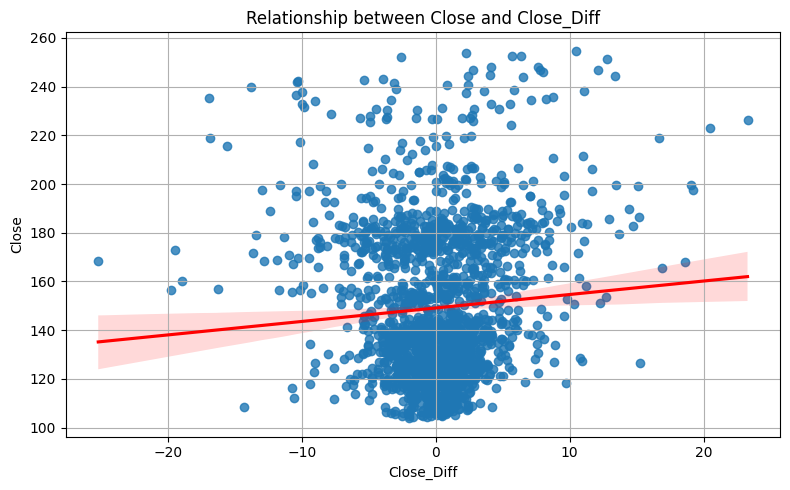


Correlation between Close and Close_Diff:
Correlation coefficient: 0.0736
p-value: 0.0013
Statistically significant correlation between Close and Close_Diff.

=== Analyzing Close with PctChange(Close) transformation ===


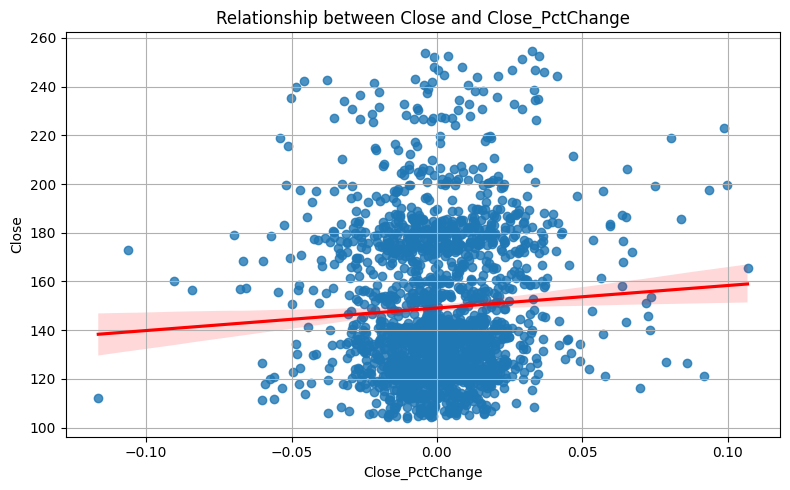


Correlation between Close and Close_PctChange:
Correlation coefficient: 0.0612
p-value: 0.0077
Statistically significant correlation between Close and Close_PctChange.

=== Analyzing Close with RollingMedian(Open) transformation ===


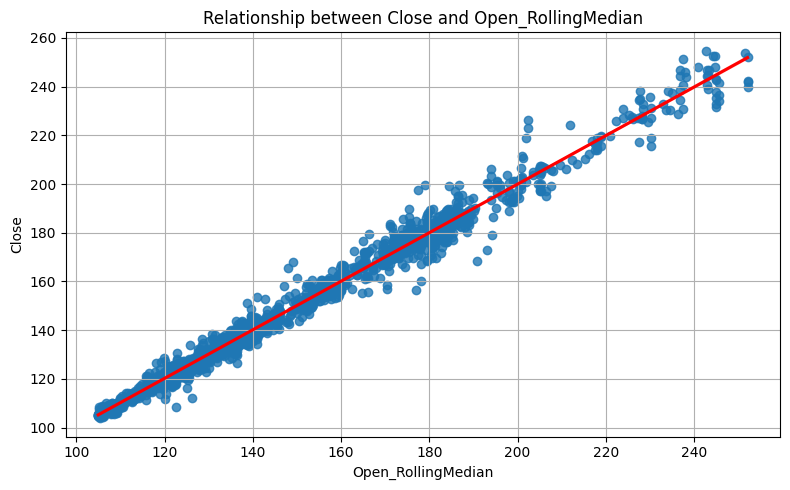


Correlation between Close and Open_RollingMedian:
Correlation coefficient: 0.9927
p-value: 0.0000
Statistically significant correlation between Close and Open_RollingMedian.


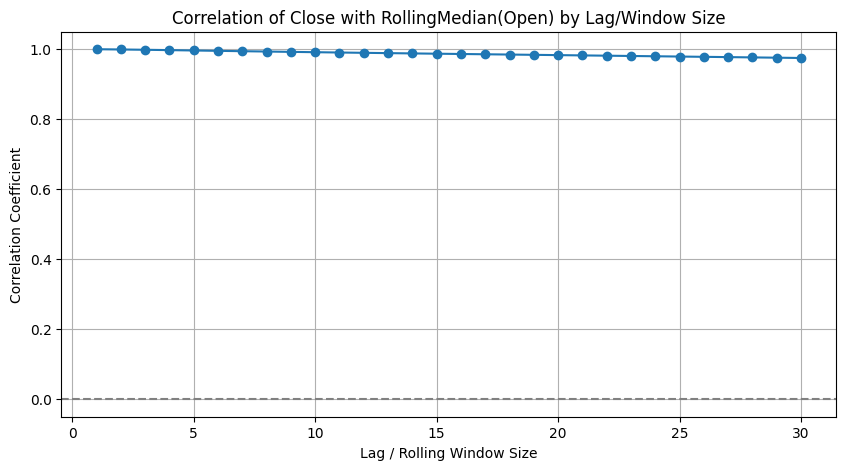


Correlation by Lag/Window Size:
Lag/Window Size 1: Correlation = 0.9994
Lag/Window Size 2: Correlation = 0.9986
Lag/Window Size 3: Correlation = 0.9977
Lag/Window Size 4: Correlation = 0.9968
Lag/Window Size 5: Correlation = 0.9957
Lag/Window Size 6: Correlation = 0.9947
Lag/Window Size 7: Correlation = 0.9937
Lag/Window Size 8: Correlation = 0.9927
Lag/Window Size 9: Correlation = 0.9918
Lag/Window Size 10: Correlation = 0.9909
Lag/Window Size 11: Correlation = 0.9900
Lag/Window Size 12: Correlation = 0.9891
Lag/Window Size 13: Correlation = 0.9882
Lag/Window Size 14: Correlation = 0.9874
Lag/Window Size 15: Correlation = 0.9866
Lag/Window Size 16: Correlation = 0.9857
Lag/Window Size 17: Correlation = 0.9849
Lag/Window Size 18: Correlation = 0.9841
Lag/Window Size 19: Correlation = 0.9833
Lag/Window Size 20: Correlation = 0.9825
Lag/Window Size 21: Correlation = 0.9817
Lag/Window Size 22: Correlation = 0.9809
Lag/Window Size 23: Correlation = 0.9801
Lag/Window Size 24: Correlation =

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_x_with_transformed_y(
    df,
    x_column='Close',
    y_column='Volume',
    y_transform='Lagged',
    lag=1,
    window=5,
    date_column='Date'
):
    """
    Analyzes the relationship between a stock metric (x) and a transformed version of another metric (y).
    Transformed values can include lagged values, rolling means, and more.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the stock data.
    x_column : str, default 'Close'
        The column to analyze ('Open', 'Close', 'High', 'Low', 'Volume').
    y_column : str, default 'Volume'
        The column to apply the transformation to ('Open', 'Close', 'High', 'Low', 'Volume').
    y_transform : str, default 'Lagged'
        The transformation to apply to the y column ('Lagged', 'RollingMean', 'RollingMedian', 'Diff', 'PctChange').
    lag : int, default 1
        The number of periods to lag (applicable if y_transform='Lagged' or 'Diff').
    window : int, default 5
        The window size for rolling calculations (applicable if y_transform is 'RollingMean' or 'RollingMedian').
    date_column : str, default 'Date'
        The date column used for sorting the data.

    Returns:
    --------
    None
    """

    # Ensure data is sorted by date
    df = df.sort_values(by=date_column)

    # Generate the transformed y_column based on the specified method
    transformed_y_column = f'{y_column}_{y_transform}'

    if y_transform == 'Lagged':
        df[transformed_y_column] = df[y_column].shift(lag)
    elif y_transform == 'RollingMean':
        df[transformed_y_column] = df[y_column].rolling(window=window).mean()
    elif y_transform == 'RollingMedian':
        df[transformed_y_column] = df[y_column].rolling(window=window).median()
    elif y_transform == 'Diff':
        df[transformed_y_column] = df[y_column].diff(lag)
    elif y_transform == 'PctChange':
        df[transformed_y_column] = df[y_column].pct_change(periods=lag)
    else:
        raise ValueError(f"Unsupported y_transform: {y_transform}")

    # Drop rows with NaN values resulting from transformations
    df = df.dropna(subset=[x_column, transformed_y_column])

    # 1. Scatter Plot with Regression Line
    plt.figure(figsize=(8, 5))
    sns.regplot(x=transformed_y_column, y=x_column, data=df, line_kws={"color": "red"})
    plt.xlabel(transformed_y_column)
    plt.ylabel(x_column)
    plt.title(f'Relationship between {x_column} and {transformed_y_column}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. Calculate and Display Correlation
    correlation, p_value = stats.pearsonr(df[transformed_y_column], df[x_column])
    print(f"\nCorrelation between {x_column} and {transformed_y_column}:")
    print(f"Correlation coefficient: {correlation:.4f}")
    print(f"p-value: {p_value:.4f}")

    if p_value < 0.05:
        print(f"Statistically significant correlation between {x_column} and {transformed_y_column}.")
    else:
        print(f"No statistically significant correlation between {x_column} and {transformed_y_column}.")

    # 3. Correlation Across Multiple Lags/Windows
    if y_transform in ['Lagged', 'RollingMean', 'RollingMedian']:
        max_lag = 30  # Example: Check up to 30 lags/rolling windows
        correlations = []
        lags = range(1, max_lag + 1)

        for lag in lags:
            if y_transform == 'Lagged':
                df[f'{transformed_y_column}_lag{lag}'] = df[y_column].shift(lag)
            elif y_transform in ['RollingMean', 'RollingMedian']:
                df[f'{transformed_y_column}_lag{lag}'] = df[y_column].rolling(window=lag).mean()

            corr = df[x_column].corr(df[f'{transformed_y_column}_lag{lag}'])
            correlations.append(corr)

        plt.figure(figsize=(10, 5))
        plt.plot(lags, correlations, marker='o')
        plt.xlabel('Lag / Rolling Window Size')
        plt.ylabel('Correlation Coefficient')
        plt.title(f'Correlation of {x_column} with {y_transform}({y_column}) by Lag/Window Size')
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.grid(True)
        plt.show()

        print("\nCorrelation by Lag/Window Size:")
        for lag, corr in zip(lags, correlations):
            print(f"Lag/Window Size {lag}: Correlation = {corr:.4f}")


# Define the configurations as a list of dictionaries
configurations = [
    {'x_column': 'Close', 'y_column': 'Volume', 'y_transform': 'Lagged', 'lag': 5},
    {'x_column': 'Close', 'y_column': 'Volume', 'y_transform': 'RollingMean', 'window': 10},
    {'x_column': 'Close', 'y_column': 'Close', 'y_transform': 'Diff', 'lag': 3},
    {'x_column': 'Close', 'y_column': 'Close', 'y_transform': 'PctChange', 'lag': 2},
    {'x_column': 'Close', 'y_column': 'Open', 'y_transform': 'RollingMedian', 'window': 7},
]

# Iterate over configurations and run the analysis function
for config in configurations:
    print(f"\n=== Analyzing {config['x_column']} with {config['y_transform']}({config['y_column']}) transformation ===")
    try:
        analyze_x_with_transformed_y(
            df,
            x_column=config['x_column'],
            y_column=config['y_column'],
            y_transform=config['y_transform'],
            lag=config.get('lag', 1),
            window=config.get('window', 5),
            date_column='Date'
        )
    except Exception as e:
        print(f"Error while processing {config}: {e}")



Top 40 Transformed Features by Correlation with 'Close':
     Close_RollingMean_window1: Correlation = 1.0000, p-value = 0.0000
       Low_RollingMean_window1: Correlation = 0.9997, p-value = 0.0000
      High_RollingMean_window1: Correlation = 0.9997, p-value = 0.0000
     Close_RollingMean_window2: Correlation = 0.9993, p-value = 0.0000
       Low_RollingMean_window2: Correlation = 0.9990, p-value = 0.0000
      High_RollingMean_window2: Correlation = 0.9989, p-value = 0.0000
     Close_RollingMean_window3: Correlation = 0.9984, p-value = 0.0000
    Volume_RollingMean_window7: Correlation = 0.4190, p-value = 0.0000
    Volume_RollingMean_window6: Correlation = 0.4088, p-value = 0.0000
    Volume_RollingMean_window5: Correlation = 0.3974, p-value = 0.0000
    Volume_RollingMean_window4: Correlation = 0.3836, p-value = 0.0000
    Volume_RollingMean_window3: Correlation = 0.3656, p-value = 0.0000
    Volume_RollingMean_window2: Correlation = 0.3402, p-value = 0.0000
    Volume_RollingM

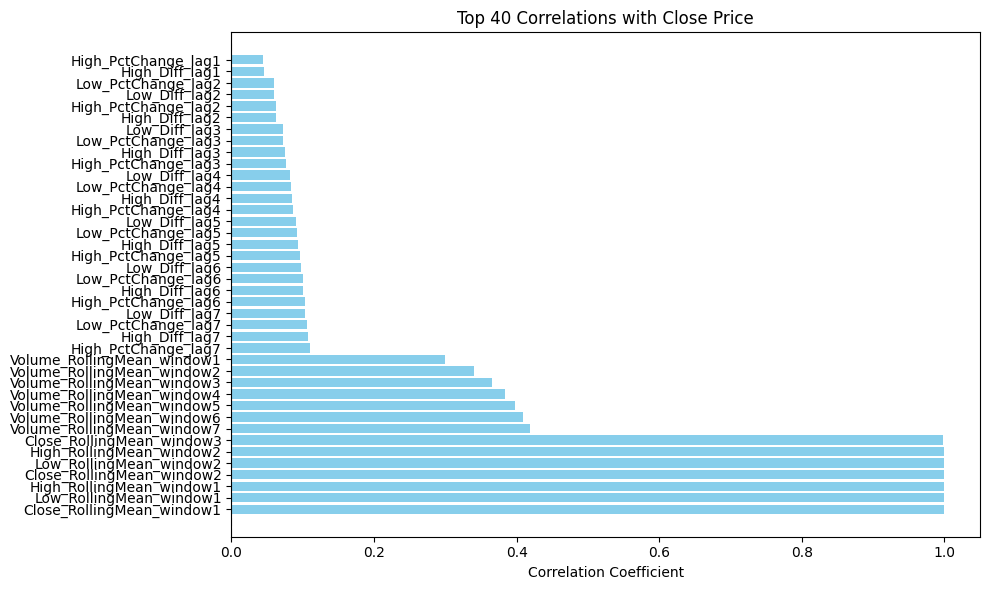

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def evaluate_correlations_with_close(
    df,
    date_column='Date',
    transformations=None,
    top_n=10
):
    """
    Evaluates which transformed feature (from Volume, High, Low) best correlates with the Close price.
    Allows custom transformations and controls the number of top features displayed.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing the stock data.
    date_column : str, default 'Date'
        The date column used for sorting the data.
    transformations : list of dict, optional
        Custom transformations to apply. Each dict should have:
        - 'y_column': the column to transform ('Volume', 'High', 'Low').
        - 'y_transform': the transformation ('RollingMean', 'Diff', 'PctChange').
        - 'param_name': the parameter name ('window' for rolling, 'lag' for diff/pct change).
        - 'param_range': range of parameter values to try.
        Example: {'y_column': 'Volume', 'y_transform': 'Lagged', 'param_name': 'lag', 'param_range': range(1, 4)}.
    top_n : int, default 10
        The number of top features to display based on correlation with 'Close'.

    Returns:
    --------
    None
    """

    # Ensure data is sorted by date
    df = df.sort_values(by=date_column)

    # Default transformations if none are provided
    if transformations is None:
        y_columns = ['Volume', 'High', 'Low']
        transformations = [
            {'y_column': y_col, 'y_transform': 'RollingMean', 'param_name': 'window', 'param_range': range(1, 4)} for y_col in y_columns
        ] + [
            {'y_column': y_col, 'y_transform': 'Diff', 'param_name': 'lag', 'param_range': range(1, 4)} for y_col in y_columns
        ] + [
            {'y_column': y_col, 'y_transform': 'PctChange', 'param_name': 'lag', 'param_range': range(1, 4)} for y_col in y_columns
        ]

    # Store results
    correlation_results = []

    # Iterate through custom transformations
    for transform in transformations:
        y_column = transform['y_column']
        y_transform = transform['y_transform']
        param_name = transform['param_name']

        for param_value in transform['param_range']:
            # Generate the transformed y_column
            transformed_y_column = f'{y_column}_{y_transform}_{param_name}{param_value}'

            # Apply the transformation
            if y_transform == 'RollingMean':
                df[transformed_y_column] = df[y_column].rolling(window=param_value).mean()
            elif y_transform == 'Diff':
                df[transformed_y_column] = df[y_column].diff(periods=param_value)
            elif y_transform == 'PctChange':
                df[transformed_y_column] = df[y_column].pct_change(periods=param_value)

            # Drop NaNs before correlation
            temp_df = df.dropna(subset=['Close', transformed_y_column])

            # Calculate correlation
            if not temp_df.empty:
                correlation, p_value = stats.pearsonr(temp_df['Close'], temp_df[transformed_y_column])
                correlation_results.append({
                    'Feature': transformed_y_column,
                    'Correlation': correlation,
                    'p-value': p_value
                })

    # Sort by absolute correlation value
    correlation_results = sorted(correlation_results, key=lambda x: abs(x['Correlation']), reverse=True)

    # Display top results
    print(f"\nTop {top_n} Transformed Features by Correlation with 'Close':")
    for result in correlation_results[:top_n]:
        print(f"{result['Feature']:>30}: Correlation = {result['Correlation']:.4f}, p-value = {result['p-value']:.4f}")

    # Visualize correlations
    plt.figure(figsize=(10, 6))
    features = [result['Feature'] for result in correlation_results[:top_n]]
    correlations = [result['Correlation'] for result in correlation_results[:top_n]]

    plt.barh(features, correlations, color='skyblue')
    plt.xlabel('Correlation Coefficient')
    plt.title(f'Top {top_n} Correlations with Close Price')
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()

# Example usage with custom transformations and top 20 features:
custom_transformations = [
    {'y_column': 'Low', 'y_transform': 'RollingMean', 'param_name': 'window', 'param_range': range(1, 3)},
    {'y_column': 'Low', 'y_transform': 'Diff', 'param_name': 'lag', 'param_range': range(1, 8)},
    {'y_column': 'Low', 'y_transform': 'PctChange', 'param_name': 'lag', 'param_range': range(1, 8)},
    {'y_column': 'High', 'y_transform': 'RollingMean', 'param_name': 'window', 'param_range': range(1, 3)},
    {'y_column': 'High', 'y_transform': 'Diff', 'param_name': 'lag', 'param_range': range(1, 8)},
    {'y_column': 'High', 'y_transform': 'PctChange', 'param_name': 'lag', 'param_range': range(1, 8)},
    {'y_column': 'Volume', 'y_transform': 'RollingMean', 'param_name': 'window', 'param_range': range(1, 8)},
    {'y_column': 'Volume', 'y_transform': 'Diff', 'param_name': 'lag', 'param_range': range(1, 8)},
    {'y_column': 'Volume', 'y_transform': 'PctChange', 'param_name': 'lag', 'param_range': range(1, 8)},

    # {'y_column': 'Open', 'y_transform': 'RollingMean', 'param_name': 'window', 'param_range': range(1, 8)},
    {'y_column': 'Close', 'y_transform': 'RollingMean', 'param_name': 'window', 'param_range': range(1, 4)}


]

evaluate_correlations_with_close(df, date_column='Date', transformations=custom_transformations, top_n=40)
